In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)
print(train_images.shape)

(60000, 28, 28, 1)


In [3]:
def create_generator():
    model = tf.keras.Sequential()

    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [4]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 256

seed = tf.random.normal([num_of_generated_examples, noise_dim])
generator = create_generator()
discriminator = create_discriminator()
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [5]:
@tf.function
def train_step(images, arg, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
    
    if arg == 1:
        print("Epoch: {}\nGenerator Loss: {}\nDiscriminator Loss: {}".format(epoch+1, gen_loss, disc_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [6]:
import os

PROJECT_ROOT_DIR = "."
SAVE_ID = "picture"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, SAVE_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
import datetime

log_dir = ".\\log"
run_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"/"
train_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/train")
val_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/validation")

Epoch: 1
Generator Loss: 0.8316540122032166
Discriminator Loss: 1.1512932777404785
Time for epoch 1 is 26.196536540985107 sec
Epoch: 2
Generator Loss: 0.9353517889976501
Discriminator Loss: 1.2191005945205688
Time for epoch 2 is 14.931370258331299 sec
Epoch: 3
Generator Loss: 0.9491144418716431
Discriminator Loss: 1.2965325117111206
Time for epoch 3 is 15.14536714553833 sec
Epoch: 4
Generator Loss: 0.8906382918357849
Discriminator Loss: 1.1921647787094116
Time for epoch 4 is 15.09454083442688 sec
Epoch: 5
Generator Loss: 0.7757525444030762
Discriminator Loss: 1.3645721673965454
Time for epoch 5 is 14.883934736251831 sec
Epoch: 6
Generator Loss: 0.8676203489303589
Discriminator Loss: 1.2311196327209473
Time for epoch 6 is 14.624348640441895 sec
Epoch: 7
Generator Loss: 0.8008431196212769
Discriminator Loss: 1.309339165687561
Time for epoch 7 is 14.721837997436523 sec
Epoch: 8
Generator Loss: 0.80100417137146
Discriminator Loss: 1.3941080570220947
Time for epoch 8 is 14.662648677825928 s

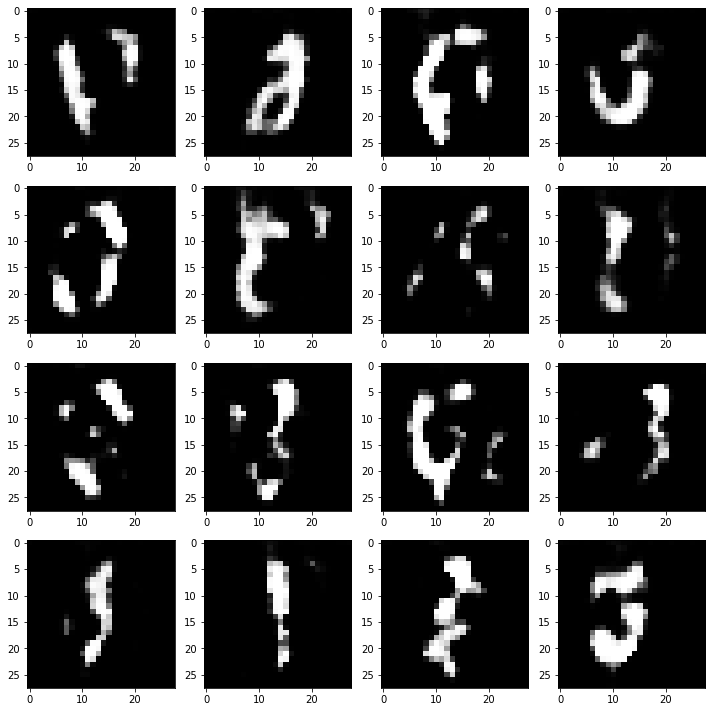

Epoch: 16
Generator Loss: 1.1244564056396484
Discriminator Loss: 1.1530022621154785
Time for epoch 16 is 14.684884548187256 sec
Epoch: 17
Generator Loss: 1.1122087240219116
Discriminator Loss: 0.9441766738891602
Time for epoch 17 is 14.636008024215698 sec
Epoch: 18
Generator Loss: 1.114136815071106
Discriminator Loss: 1.1436017751693726
Time for epoch 18 is 14.640372276306152 sec
Epoch: 19
Generator Loss: 1.053572416305542
Discriminator Loss: 1.2102192640304565
Time for epoch 19 is 14.658387422561646 sec
Epoch: 20
Generator Loss: 1.2210888862609863
Discriminator Loss: 1.008593201637268
Time for epoch 20 is 14.627408742904663 sec
Epoch: 21
Generator Loss: 1.070969820022583
Discriminator Loss: 0.9789339900016785
Time for epoch 21 is 14.594807147979736 sec
Epoch: 22
Generator Loss: 1.4125981330871582
Discriminator Loss: 1.0317891836166382
Time for epoch 22 is 14.626254081726074 sec
Epoch: 23
Generator Loss: 1.1429858207702637
Discriminator Loss: 1.177575945854187
Time for epoch 23 is 14.6

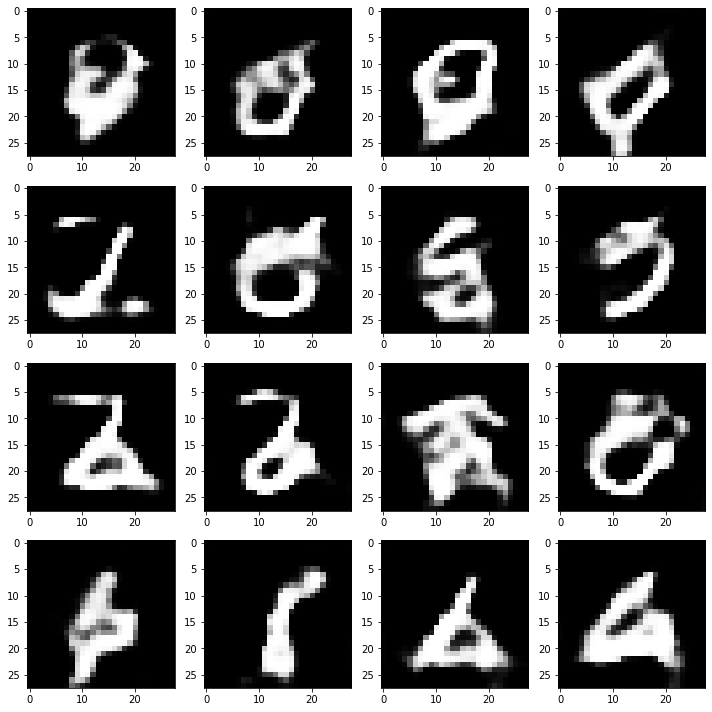

Epoch: 31
Generator Loss: 1.077880859375
Discriminator Loss: 1.3113362789154053
Time for epoch 31 is 15.572920083999634 sec
Epoch: 32
Generator Loss: 1.1775063276290894
Discriminator Loss: 1.130659580230713
Time for epoch 32 is 15.35071086883545 sec
Epoch: 33
Generator Loss: 0.99185711145401
Discriminator Loss: 1.11832857131958
Time for epoch 33 is 15.036742448806763 sec
Epoch: 34
Generator Loss: 1.2177166938781738
Discriminator Loss: 1.0930702686309814
Time for epoch 34 is 15.10618281364441 sec
Epoch: 35
Generator Loss: 0.9513567090034485
Discriminator Loss: 1.2645132541656494
Time for epoch 35 is 15.053573846817017 sec
Epoch: 36
Generator Loss: 0.9138014912605286
Discriminator Loss: 1.3186531066894531
Time for epoch 36 is 15.179654598236084 sec
Epoch: 37
Generator Loss: 0.9244554042816162
Discriminator Loss: 1.326395869255066
Time for epoch 37 is 15.213319063186646 sec
Epoch: 38
Generator Loss: 0.929690957069397
Discriminator Loss: 1.271285057067871
Time for epoch 38 is 15.1304860115

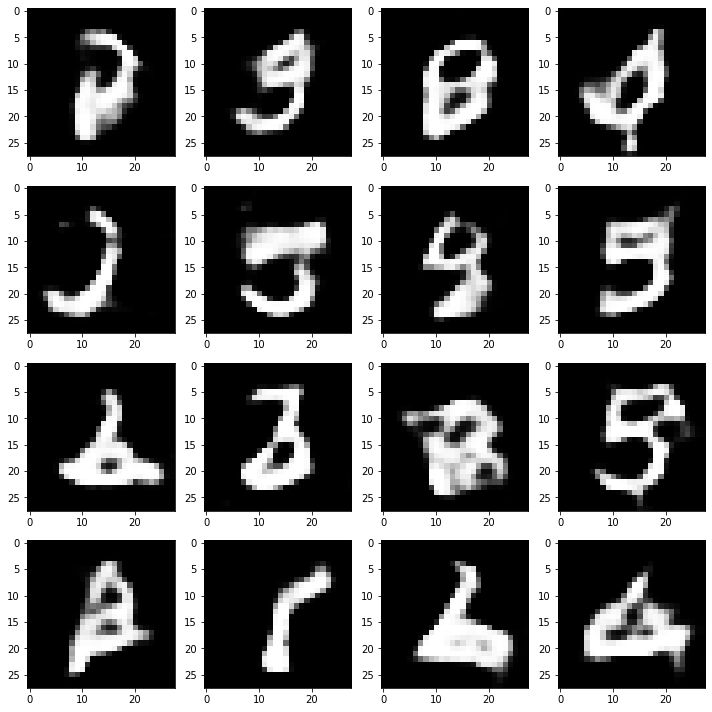

Epoch: 46
Generator Loss: 0.8651806712150574
Discriminator Loss: 1.3069782257080078
Time for epoch 46 is 14.734359979629517 sec
Epoch: 47
Generator Loss: 1.0517265796661377
Discriminator Loss: 1.1046407222747803
Time for epoch 47 is 15.294202089309692 sec
Epoch: 48
Generator Loss: 0.8784869909286499
Discriminator Loss: 1.3722494840621948
Time for epoch 48 is 14.986031532287598 sec
Epoch: 49
Generator Loss: 1.0500601530075073
Discriminator Loss: 1.092977523803711
Time for epoch 49 is 15.276805877685547 sec
Epoch: 50
Generator Loss: 1.017909049987793
Discriminator Loss: 1.1190299987792969
Time for epoch 50 is 15.331367015838623 sec
Epoch: 51
Generator Loss: 1.0774176120758057
Discriminator Loss: 1.1144225597381592
Time for epoch 51 is 15.248535394668579 sec
Epoch: 52
Generator Loss: 0.9211481809616089
Discriminator Loss: 1.1284033060073853
Time for epoch 52 is 15.220758199691772 sec
Epoch: 53
Generator Loss: 0.950187623500824
Discriminator Loss: 1.1777944564819336
Time for epoch 53 is 15

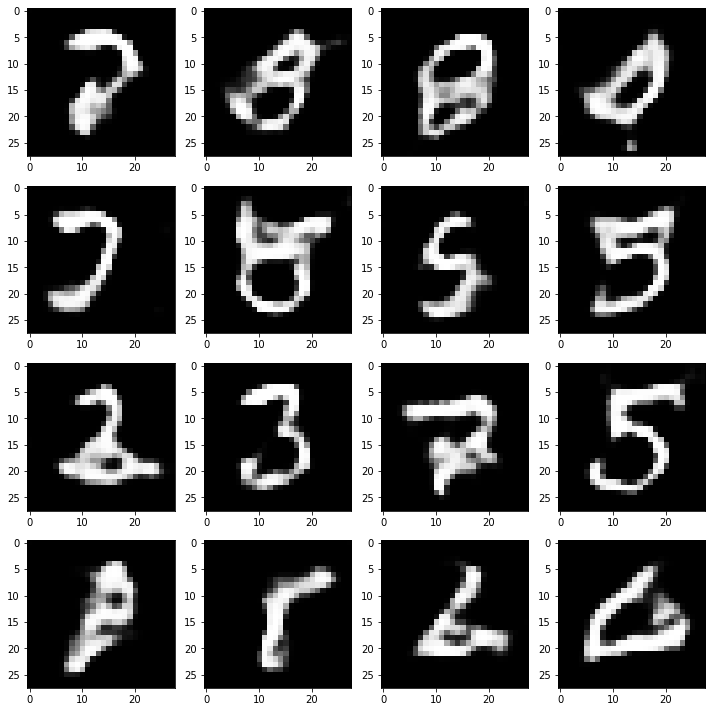

Epoch: 61
Generator Loss: 0.8800603151321411
Discriminator Loss: 1.38461434841156
Time for epoch 61 is 14.749675750732422 sec
Epoch: 62
Generator Loss: 0.808474063873291
Discriminator Loss: 1.349760890007019
Time for epoch 62 is 14.660151243209839 sec
Epoch: 63
Generator Loss: 1.0117954015731812
Discriminator Loss: 1.0687501430511475
Time for epoch 63 is 14.63748049736023 sec
Epoch: 64
Generator Loss: 1.0492769479751587
Discriminator Loss: 1.1710076332092285
Time for epoch 64 is 14.632461071014404 sec
Epoch: 65
Generator Loss: 1.0977287292480469
Discriminator Loss: 1.1431849002838135
Time for epoch 65 is 14.677509784698486 sec
Epoch: 66
Generator Loss: 1.041912317276001
Discriminator Loss: 1.2993590831756592
Time for epoch 66 is 14.677864074707031 sec
Epoch: 67
Generator Loss: 0.9380822777748108
Discriminator Loss: 1.1968562602996826
Time for epoch 67 is 14.690458536148071 sec
Epoch: 68
Generator Loss: 0.9058098196983337
Discriminator Loss: 1.3901774883270264
Time for epoch 68 is 14.63

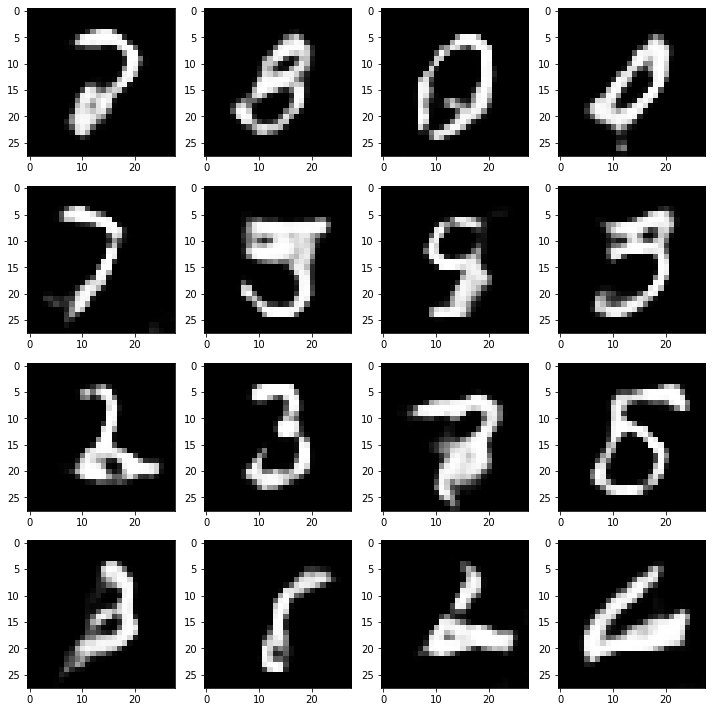

Epoch: 76
Generator Loss: 0.8760970830917358
Discriminator Loss: 1.3895142078399658
Time for epoch 76 is 14.761279344558716 sec
Epoch: 77
Generator Loss: 0.8853324055671692
Discriminator Loss: 1.3371808528900146
Time for epoch 77 is 14.623792171478271 sec
Epoch: 78
Generator Loss: 0.9705215096473694
Discriminator Loss: 1.264415979385376
Time for epoch 78 is 14.685399532318115 sec
Epoch: 79
Generator Loss: 0.8850934505462646
Discriminator Loss: 1.2975938320159912
Time for epoch 79 is 14.651782989501953 sec
Epoch: 80
Generator Loss: 0.9836137294769287
Discriminator Loss: 1.3316808938980103
Time for epoch 80 is 14.659779787063599 sec
Epoch: 81
Generator Loss: 0.8494198322296143
Discriminator Loss: 1.5156619548797607
Time for epoch 81 is 14.634480953216553 sec
Epoch: 82
Generator Loss: 0.913796603679657
Discriminator Loss: 1.3413918018341064
Time for epoch 82 is 14.661064386367798 sec
Epoch: 83
Generator Loss: 0.9537020921707153
Discriminator Loss: 1.282055377960205
Time for epoch 83 is 14

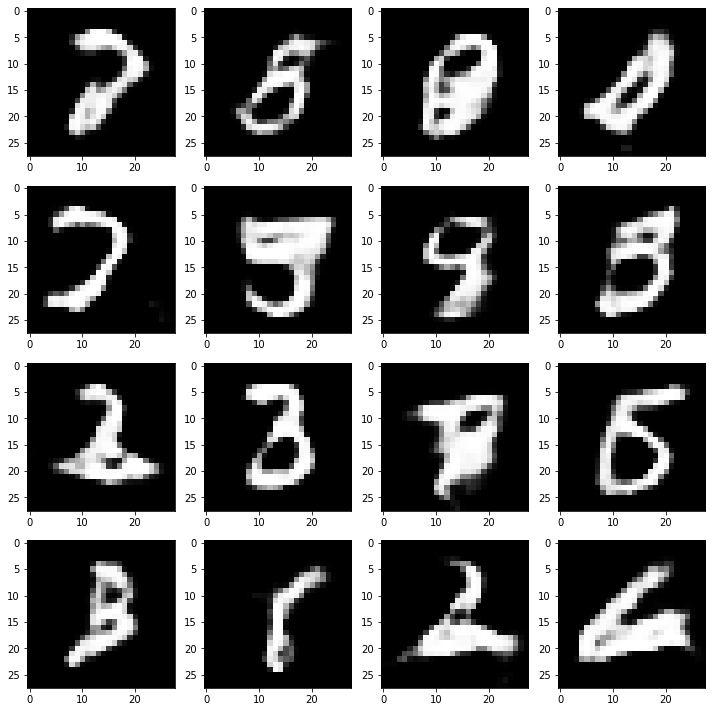

Epoch: 91
Generator Loss: 0.7871867418289185
Discriminator Loss: 1.2634040117263794
Time for epoch 91 is 14.674176454544067 sec
Epoch: 92
Generator Loss: 0.8295579552650452
Discriminator Loss: 1.226529598236084
Time for epoch 92 is 14.699056148529053 sec
Epoch: 93
Generator Loss: 0.9555106163024902
Discriminator Loss: 1.1867005825042725
Time for epoch 93 is 14.632229566574097 sec
Epoch: 94
Generator Loss: 0.8959773182868958
Discriminator Loss: 1.2508289813995361
Time for epoch 94 is 14.62953519821167 sec
Epoch: 95
Generator Loss: 0.8886664509773254
Discriminator Loss: 1.2300598621368408
Time for epoch 95 is 14.649425268173218 sec
Epoch: 96
Generator Loss: 0.9428833723068237
Discriminator Loss: 1.276590347290039
Time for epoch 96 is 14.635866403579712 sec
Epoch: 97
Generator Loss: 0.8861760497093201
Discriminator Loss: 1.2785348892211914
Time for epoch 97 is 14.604318618774414 sec
Epoch: 98
Generator Loss: 1.0938467979431152
Discriminator Loss: 1.1480132341384888
Time for epoch 98 is 14

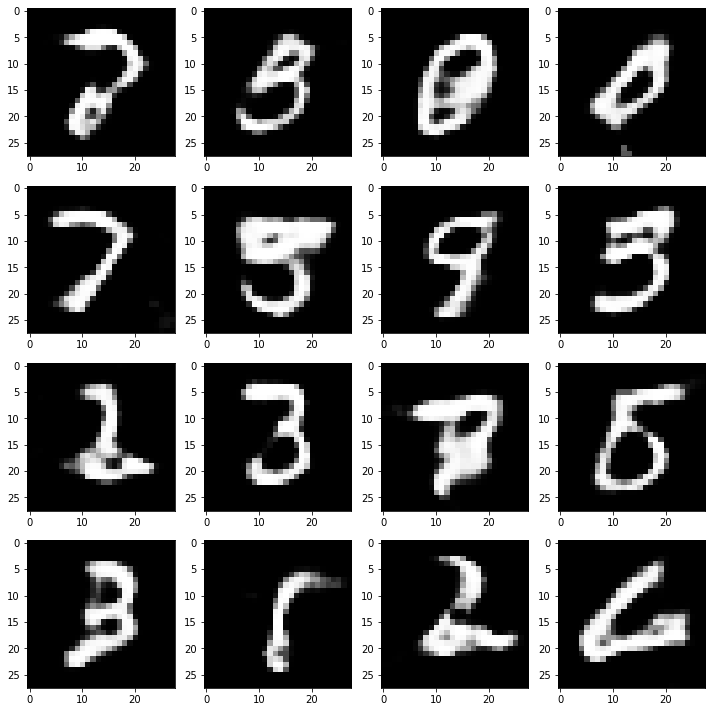

Epoch: 106
Generator Loss: 0.9588810205459595
Discriminator Loss: 1.1495702266693115
Time for epoch 106 is 14.69180417060852 sec
Epoch: 107
Generator Loss: 0.8798502683639526
Discriminator Loss: 1.2859466075897217
Time for epoch 107 is 14.677387952804565 sec
Epoch: 108
Generator Loss: 0.8663618564605713
Discriminator Loss: 1.239431381225586
Time for epoch 108 is 14.645482063293457 sec
Epoch: 109
Generator Loss: 0.9909358024597168
Discriminator Loss: 1.1413475275039673
Time for epoch 109 is 14.634892702102661 sec
Epoch: 110
Generator Loss: 1.0151069164276123
Discriminator Loss: 1.1219838857650757
Time for epoch 110 is 14.679901123046875 sec
Epoch: 111
Generator Loss: 0.8383987545967102
Discriminator Loss: 1.1826390027999878
Time for epoch 111 is 14.663777351379395 sec
Epoch: 112
Generator Loss: 0.949583113193512
Discriminator Loss: 1.1914279460906982
Time for epoch 112 is 14.61860966682434 sec
Epoch: 113
Generator Loss: 0.9887597560882568
Discriminator Loss: 1.2170665264129639
Time for 

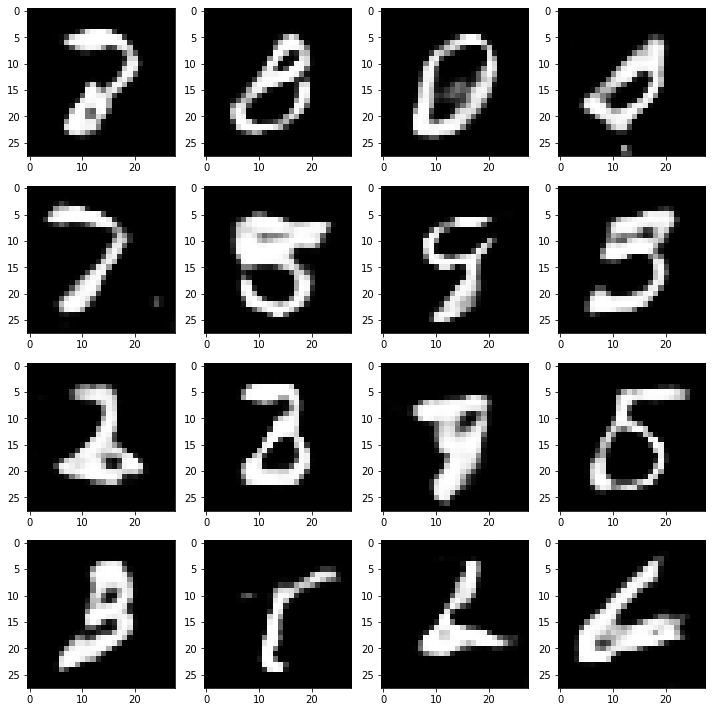

Epoch: 121
Generator Loss: 0.8271409869194031
Discriminator Loss: 1.2757759094238281
Time for epoch 121 is 14.786289691925049 sec
Epoch: 122
Generator Loss: 0.9445785284042358
Discriminator Loss: 1.2543048858642578
Time for epoch 122 is 14.635731220245361 sec
Epoch: 123
Generator Loss: 1.031956672668457
Discriminator Loss: 1.2226365804672241
Time for epoch 123 is 14.629847526550293 sec
Epoch: 124
Generator Loss: 1.0102050304412842
Discriminator Loss: 1.1199872493743896
Time for epoch 124 is 14.671023607254028 sec
Epoch: 125
Generator Loss: 1.0311903953552246
Discriminator Loss: 1.313049077987671
Time for epoch 125 is 14.616900205612183 sec
Epoch: 126
Generator Loss: 0.9220792055130005
Discriminator Loss: 1.411352515220642
Time for epoch 126 is 14.644897222518921 sec
Epoch: 127
Generator Loss: 1.0241416692733765
Discriminator Loss: 1.207660436630249
Time for epoch 127 is 14.687415599822998 sec
Epoch: 128
Generator Loss: 0.9129021763801575
Discriminator Loss: 1.1531709432601929
Time for 

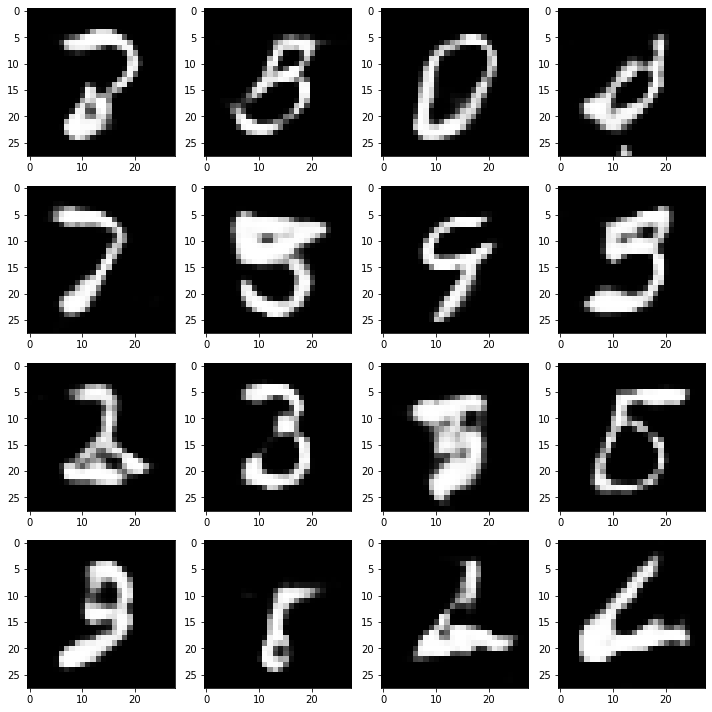

Epoch: 136
Generator Loss: 0.9316785931587219
Discriminator Loss: 1.2620612382888794
Time for epoch 136 is 14.79238247871399 sec
Epoch: 137
Generator Loss: 0.9002902507781982
Discriminator Loss: 1.1435446739196777
Time for epoch 137 is 14.671120882034302 sec
Epoch: 138
Generator Loss: 0.9408976435661316
Discriminator Loss: 1.1381359100341797
Time for epoch 138 is 14.642580509185791 sec
Epoch: 139
Generator Loss: 0.9518893957138062
Discriminator Loss: 1.2831370830535889
Time for epoch 139 is 14.651942491531372 sec
Epoch: 140
Generator Loss: 0.9165127277374268
Discriminator Loss: 1.3469475507736206
Time for epoch 140 is 14.69624662399292 sec
Epoch: 141
Generator Loss: 0.8508996367454529
Discriminator Loss: 1.2727875709533691
Time for epoch 141 is 14.670661449432373 sec
Epoch: 142
Generator Loss: 1.1211051940917969
Discriminator Loss: 1.1479603052139282
Time for epoch 142 is 14.647555351257324 sec
Epoch: 143
Generator Loss: 1.0753504037857056
Discriminator Loss: 1.2639477252960205
Time fo

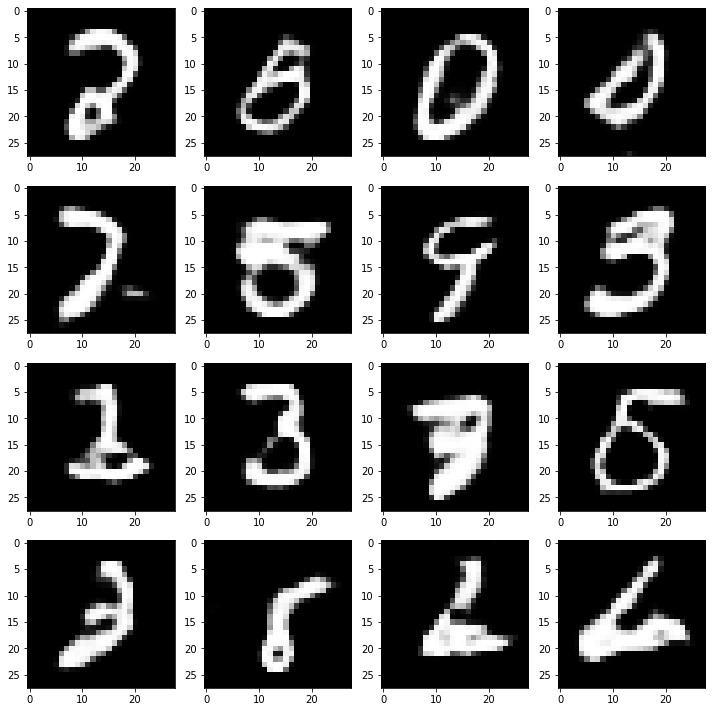

Epoch: 151
Generator Loss: 1.010389804840088
Discriminator Loss: 1.2025365829467773
Time for epoch 151 is 14.812499046325684 sec
Epoch: 152
Generator Loss: 0.8333302140235901
Discriminator Loss: 1.360183596611023
Time for epoch 152 is 14.65630841255188 sec
Epoch: 153
Generator Loss: 0.8408634066581726
Discriminator Loss: 1.1947146654129028
Time for epoch 153 is 14.660064935684204 sec
Epoch: 154
Generator Loss: 0.9244279861450195
Discriminator Loss: 1.2592006921768188
Time for epoch 154 is 14.644887447357178 sec
Epoch: 155
Generator Loss: 0.9255773425102234
Discriminator Loss: 1.2922654151916504
Time for epoch 155 is 14.724920749664307 sec
Epoch: 156
Generator Loss: 0.9453884363174438
Discriminator Loss: 1.2825758457183838
Time for epoch 156 is 14.66289496421814 sec
Epoch: 157
Generator Loss: 0.9420561790466309
Discriminator Loss: 1.2606658935546875
Time for epoch 157 is 14.716883897781372 sec
Epoch: 158
Generator Loss: 0.8491118550300598
Discriminator Loss: 1.2861545085906982
Time for 

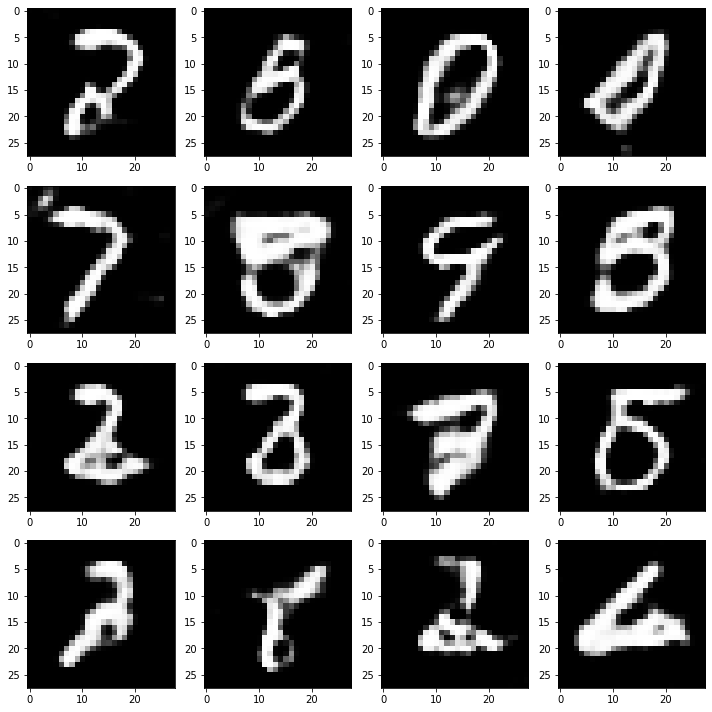

Epoch: 166
Generator Loss: 0.9762325882911682
Discriminator Loss: 1.2107977867126465
Time for epoch 166 is 14.618617057800293 sec
Epoch: 167
Generator Loss: 0.9516492486000061
Discriminator Loss: 1.246694803237915
Time for epoch 167 is 14.66523790359497 sec
Epoch: 168
Generator Loss: 0.8251932263374329
Discriminator Loss: 1.3458211421966553
Time for epoch 168 is 14.707867860794067 sec
Epoch: 169
Generator Loss: 0.9816401600837708
Discriminator Loss: 1.1583538055419922
Time for epoch 169 is 14.650155782699585 sec
Epoch: 170
Generator Loss: 0.8841109871864319
Discriminator Loss: 1.2573868036270142
Time for epoch 170 is 14.616776466369629 sec
Epoch: 171
Generator Loss: 0.8659637570381165
Discriminator Loss: 1.245776891708374
Time for epoch 171 is 14.628427267074585 sec
Epoch: 172
Generator Loss: 0.9004395008087158
Discriminator Loss: 1.2115719318389893
Time for epoch 172 is 14.685116052627563 sec
Epoch: 173
Generator Loss: 0.8811224699020386
Discriminator Loss: 1.2538386583328247
Time for

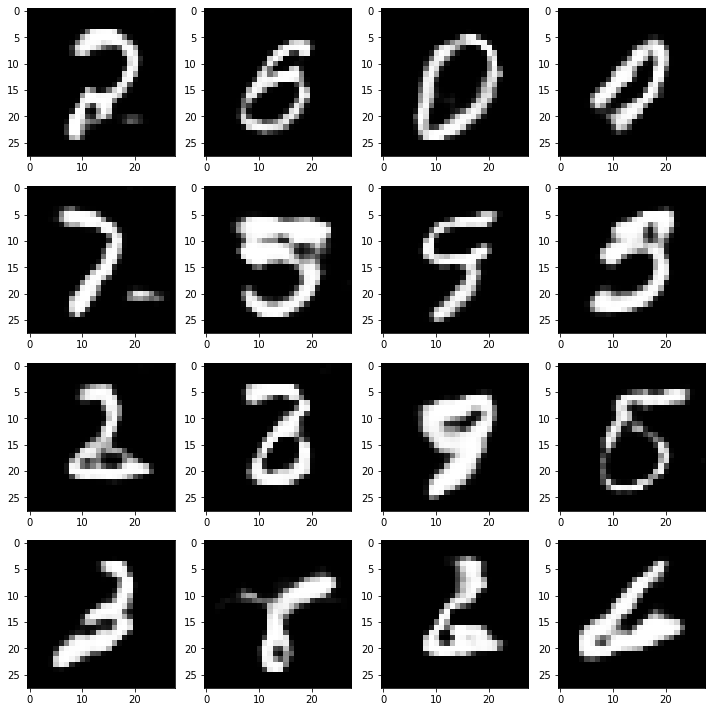

Epoch: 181
Generator Loss: 0.850957989692688
Discriminator Loss: 1.2791905403137207
Time for epoch 181 is 14.697197914123535 sec
Epoch: 182
Generator Loss: 0.9176071286201477
Discriminator Loss: 1.2324702739715576
Time for epoch 182 is 14.659860134124756 sec
Epoch: 183
Generator Loss: 0.8929769992828369
Discriminator Loss: 1.2341766357421875
Time for epoch 183 is 14.64192533493042 sec
Epoch: 184
Generator Loss: 0.884027898311615
Discriminator Loss: 1.289839506149292
Time for epoch 184 is 14.651544570922852 sec
Epoch: 185
Generator Loss: 0.7778619527816772
Discriminator Loss: 1.4002697467803955
Time for epoch 185 is 14.680323123931885 sec
Epoch: 186
Generator Loss: 0.8747096061706543
Discriminator Loss: 1.2590200901031494
Time for epoch 186 is 14.657926797866821 sec
Epoch: 187
Generator Loss: 0.8197038173675537
Discriminator Loss: 1.2082014083862305
Time for epoch 187 is 14.645108461380005 sec
Epoch: 188
Generator Loss: 1.0464061498641968
Discriminator Loss: 1.1705244779586792
Time for 

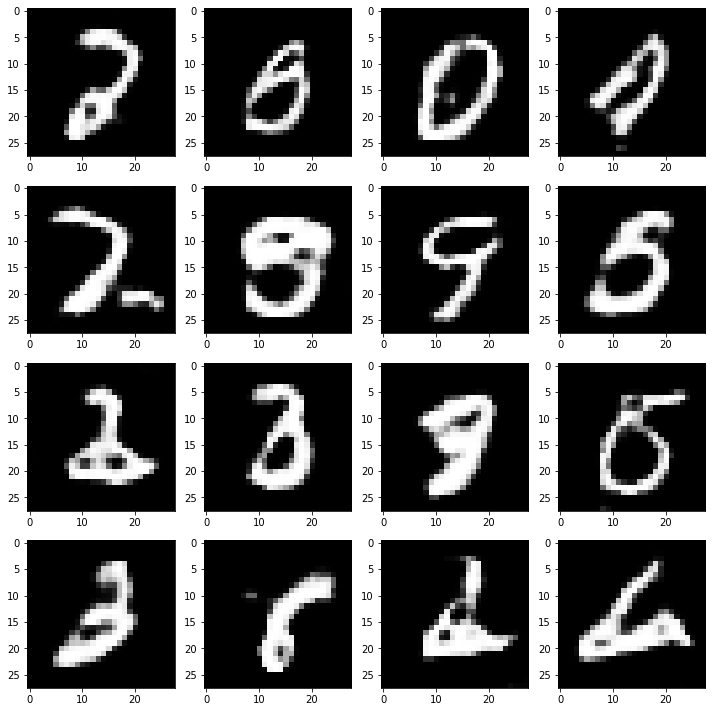

Epoch: 196
Generator Loss: 0.835077702999115
Discriminator Loss: 1.2813589572906494
Time for epoch 196 is 14.769131660461426 sec
Epoch: 197
Generator Loss: 0.972233235836029
Discriminator Loss: 1.1716699600219727
Time for epoch 197 is 14.649515867233276 sec
Epoch: 198
Generator Loss: 0.8846622705459595
Discriminator Loss: 1.2152884006500244
Time for epoch 198 is 14.669274091720581 sec
Epoch: 199
Generator Loss: 0.9378265738487244
Discriminator Loss: 1.2650277614593506
Time for epoch 199 is 14.646262168884277 sec
Epoch: 200
Generator Loss: 0.8186466097831726
Discriminator Loss: 1.3469843864440918
Time for epoch 200 is 14.6419095993042 sec
Epoch: 201
Generator Loss: 0.9298498630523682
Discriminator Loss: 1.224319577217102
Time for epoch 201 is 14.670420169830322 sec
Epoch: 202
Generator Loss: 0.8778225183486938
Discriminator Loss: 1.1879661083221436
Time for epoch 202 is 14.676875352859497 sec
Epoch: 203
Generator Loss: 0.8856520652770996
Discriminator Loss: 1.1667850017547607
Time for e

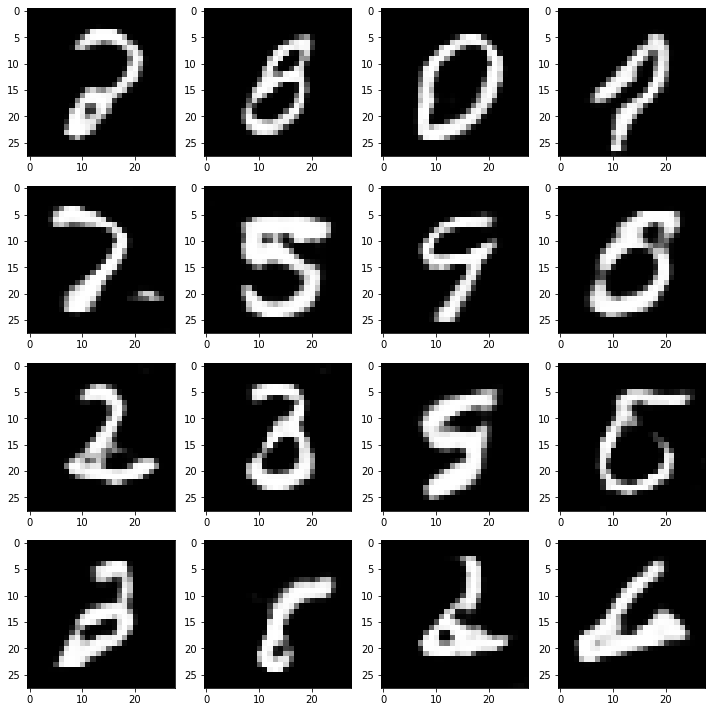

Epoch: 211
Generator Loss: 0.7710260152816772
Discriminator Loss: 1.2923450469970703
Time for epoch 211 is 14.884783267974854 sec
Epoch: 212
Generator Loss: 0.8403637409210205
Discriminator Loss: 1.316277265548706
Time for epoch 212 is 14.636751890182495 sec
Epoch: 213
Generator Loss: 0.9634308815002441
Discriminator Loss: 1.280916690826416
Time for epoch 213 is 14.669523477554321 sec
Epoch: 214
Generator Loss: 0.8974167108535767
Discriminator Loss: 1.1836912631988525
Time for epoch 214 is 14.650390148162842 sec
Epoch: 215
Generator Loss: 0.7639065384864807
Discriminator Loss: 1.3402955532073975
Time for epoch 215 is 14.641086101531982 sec
Epoch: 216
Generator Loss: 0.8893895149230957
Discriminator Loss: 1.3112263679504395
Time for epoch 216 is 14.65072512626648 sec
Epoch: 217
Generator Loss: 0.8016327023506165
Discriminator Loss: 1.2732882499694824
Time for epoch 217 is 14.688149213790894 sec
Epoch: 218
Generator Loss: 0.9629184603691101
Discriminator Loss: 1.1922842264175415
Time for

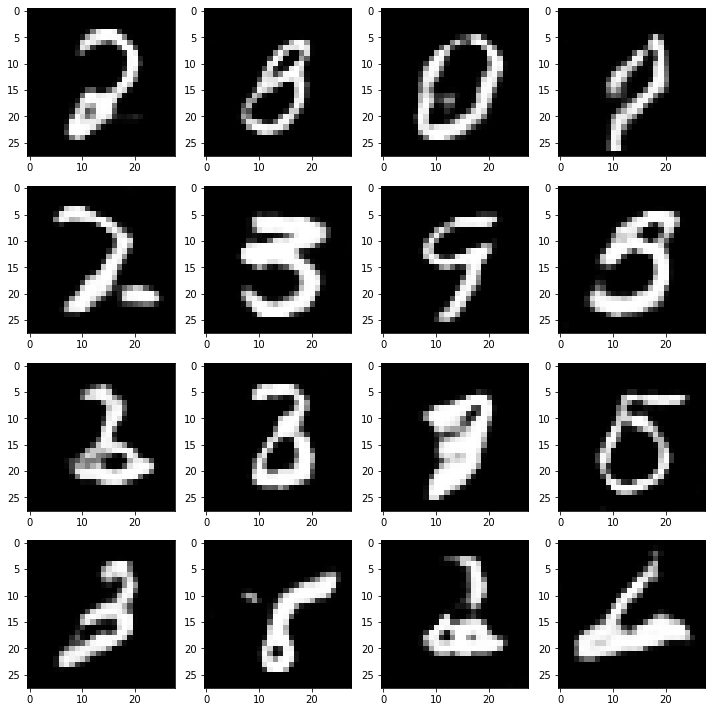

Epoch: 226
Generator Loss: 0.8657835125923157
Discriminator Loss: 1.3277817964553833
Time for epoch 226 is 14.671526908874512 sec
Epoch: 227
Generator Loss: 0.870542049407959
Discriminator Loss: 1.2957043647766113
Time for epoch 227 is 14.685611486434937 sec
Epoch: 228
Generator Loss: 0.7991387844085693
Discriminator Loss: 1.317582130432129
Time for epoch 228 is 14.65025520324707 sec
Epoch: 229
Generator Loss: 0.8617462515830994
Discriminator Loss: 1.2139699459075928
Time for epoch 229 is 14.661153793334961 sec
Epoch: 230
Generator Loss: 0.9430666565895081
Discriminator Loss: 1.263033390045166
Time for epoch 230 is 14.640682935714722 sec
Epoch: 231
Generator Loss: 0.8647049069404602
Discriminator Loss: 1.334855318069458
Time for epoch 231 is 14.632283210754395 sec
Epoch: 232
Generator Loss: 0.9619671106338501
Discriminator Loss: 1.3140041828155518
Time for epoch 232 is 14.665998458862305 sec
Epoch: 233
Generator Loss: 0.9444777965545654
Discriminator Loss: 1.2712604999542236
Time for e

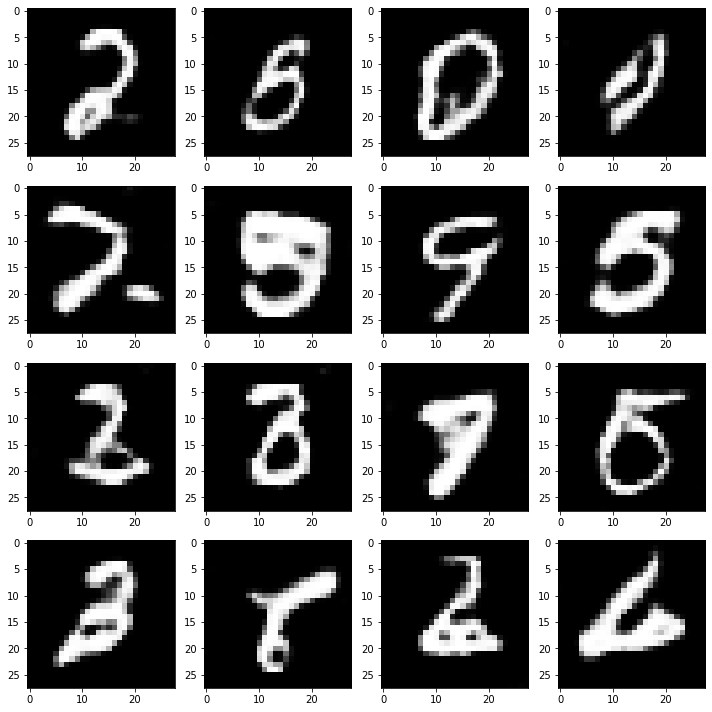

Epoch: 241
Generator Loss: 0.789445698261261
Discriminator Loss: 1.2755992412567139
Time for epoch 241 is 14.684859037399292 sec
Epoch: 242
Generator Loss: 0.9220216274261475
Discriminator Loss: 1.273425817489624
Time for epoch 242 is 14.64791464805603 sec
Epoch: 243
Generator Loss: 0.8444594144821167
Discriminator Loss: 1.2555643320083618
Time for epoch 243 is 14.662380695343018 sec
Epoch: 244
Generator Loss: 0.8416483402252197
Discriminator Loss: 1.3164973258972168
Time for epoch 244 is 14.671718120574951 sec
Epoch: 245
Generator Loss: 0.8384239077568054
Discriminator Loss: 1.2984082698822021
Time for epoch 245 is 14.647615909576416 sec
Epoch: 246
Generator Loss: 0.8680152893066406
Discriminator Loss: 1.2438204288482666
Time for epoch 246 is 14.627652406692505 sec
Epoch: 247
Generator Loss: 0.880799412727356
Discriminator Loss: 1.2925060987472534
Time for epoch 247 is 14.621965885162354 sec
Epoch: 248
Generator Loss: 0.867693305015564
Discriminator Loss: 1.288200855255127
Time for ep

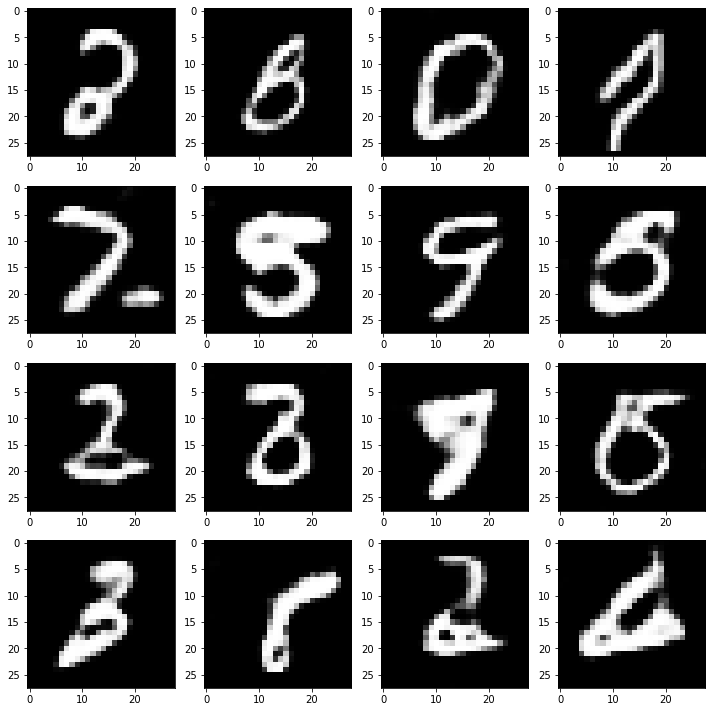

Epoch: 256
Generator Loss: 0.9067106246948242
Discriminator Loss: 1.2768394947052002
Time for epoch 256 is 14.821638822555542 sec
Epoch: 257
Generator Loss: 0.8657684922218323
Discriminator Loss: 1.374957799911499
Time for epoch 257 is 14.668052673339844 sec
Epoch: 258
Generator Loss: 0.9111897945404053
Discriminator Loss: 1.3060317039489746
Time for epoch 258 is 14.658012866973877 sec
Epoch: 259
Generator Loss: 0.7818127274513245
Discriminator Loss: 1.3386690616607666
Time for epoch 259 is 14.636679410934448 sec
Epoch: 260
Generator Loss: 0.9299145936965942
Discriminator Loss: 1.243316411972046
Time for epoch 260 is 14.65202808380127 sec
Epoch: 261
Generator Loss: 0.8892853260040283
Discriminator Loss: 1.277590274810791
Time for epoch 261 is 14.643996477127075 sec
Epoch: 262
Generator Loss: 0.7731878161430359
Discriminator Loss: 1.3380072116851807
Time for epoch 262 is 14.658092737197876 sec
Epoch: 263
Generator Loss: 0.8320091366767883
Discriminator Loss: 1.2561709880828857
Time for 

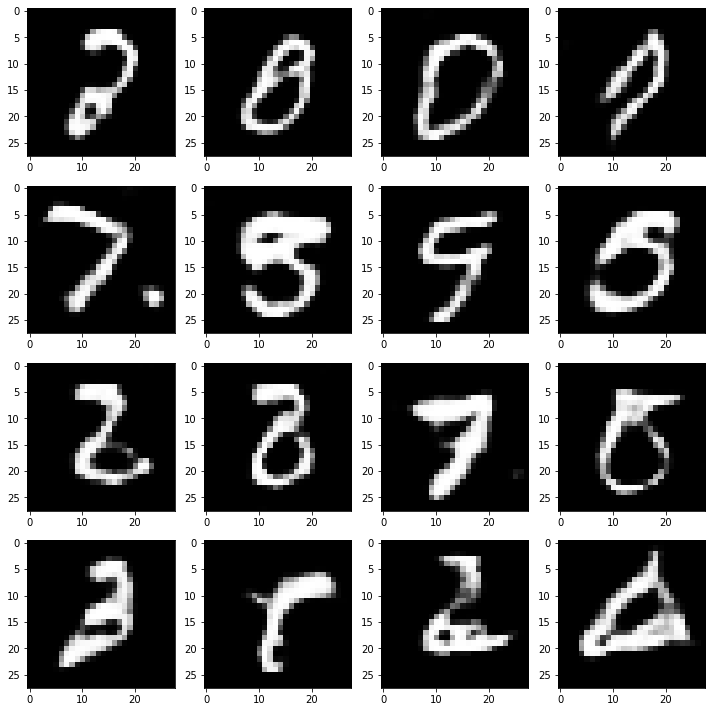

Epoch: 271
Generator Loss: 0.9374157190322876
Discriminator Loss: 1.2696452140808105
Time for epoch 271 is 14.971856355667114 sec
Epoch: 272
Generator Loss: 0.9147589206695557
Discriminator Loss: 1.1586971282958984
Time for epoch 272 is 14.705031156539917 sec
Epoch: 273
Generator Loss: 0.8071255683898926
Discriminator Loss: 1.3102166652679443
Time for epoch 273 is 14.799766540527344 sec
Epoch: 274
Generator Loss: 0.8909387588500977
Discriminator Loss: 1.363004446029663
Time for epoch 274 is 14.655568599700928 sec
Epoch: 275
Generator Loss: 0.918219804763794
Discriminator Loss: 1.2402256727218628
Time for epoch 275 is 14.65941333770752 sec
Epoch: 276
Generator Loss: 0.7612234950065613
Discriminator Loss: 1.3197275400161743
Time for epoch 276 is 14.640127182006836 sec
Epoch: 277
Generator Loss: 0.8961812257766724
Discriminator Loss: 1.162398338317871
Time for epoch 277 is 14.677817344665527 sec
Epoch: 278
Generator Loss: 0.8431347608566284
Discriminator Loss: 1.3519444465637207
Time for 

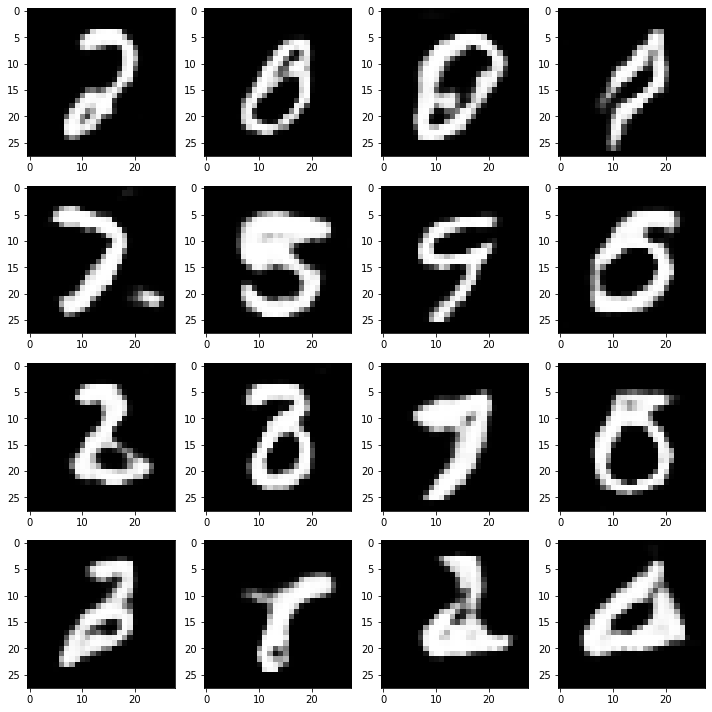

Epoch: 286
Generator Loss: 0.9523143172264099
Discriminator Loss: 1.3200719356536865
Time for epoch 286 is 14.857453107833862 sec
Epoch: 287
Generator Loss: 0.8625768423080444
Discriminator Loss: 1.3140472173690796
Time for epoch 287 is 14.6823251247406 sec
Epoch: 288
Generator Loss: 0.9031574130058289
Discriminator Loss: 1.268686294555664
Time for epoch 288 is 14.667937994003296 sec
Epoch: 289
Generator Loss: 0.937657356262207
Discriminator Loss: 1.2526319026947021
Time for epoch 289 is 14.633131742477417 sec
Epoch: 290
Generator Loss: 0.8243591785430908
Discriminator Loss: 1.2903733253479004
Time for epoch 290 is 14.771533966064453 sec
Epoch: 291
Generator Loss: 0.8330926299095154
Discriminator Loss: 1.3078699111938477
Time for epoch 291 is 14.656758069992065 sec
Epoch: 292
Generator Loss: 0.9349756836891174
Discriminator Loss: 1.3060343265533447
Time for epoch 292 is 14.662047147750854 sec
Epoch: 293
Generator Loss: 0.8554934859275818
Discriminator Loss: 1.3395028114318848
Time for 

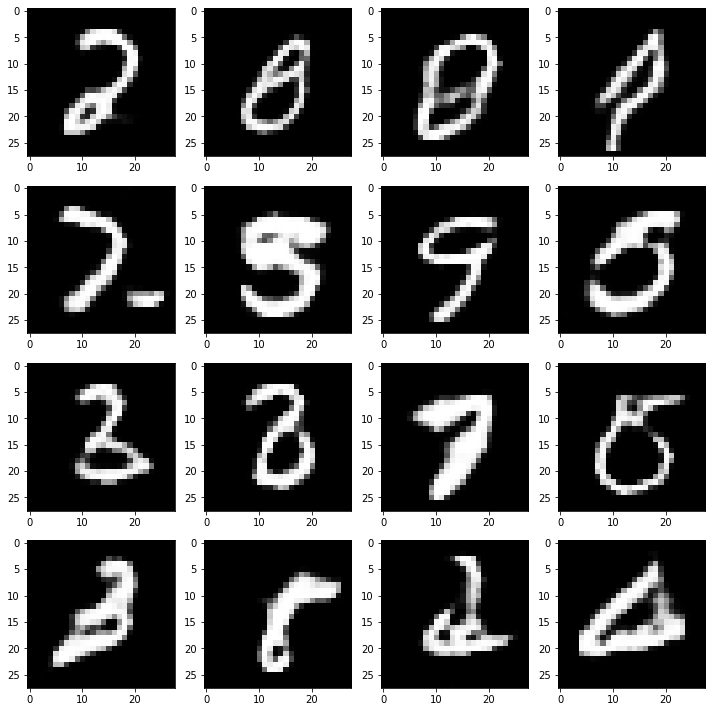

Epoch: 301
Generator Loss: 0.8935965299606323
Discriminator Loss: 1.305880069732666
Time for epoch 301 is 14.714354276657104 sec
Epoch: 302
Generator Loss: 0.8209905028343201
Discriminator Loss: 1.3065121173858643
Time for epoch 302 is 14.654007196426392 sec
Epoch: 303
Generator Loss: 0.8079445958137512
Discriminator Loss: 1.254319429397583
Time for epoch 303 is 14.668060779571533 sec
Epoch: 304
Generator Loss: 0.875382125377655
Discriminator Loss: 1.2071539163589478
Time for epoch 304 is 14.63477897644043 sec
Epoch: 305
Generator Loss: 0.8676189184188843
Discriminator Loss: 1.24000883102417
Time for epoch 305 is 14.652564287185669 sec
Epoch: 306
Generator Loss: 0.8083292841911316
Discriminator Loss: 1.278638482093811
Time for epoch 306 is 14.658317804336548 sec
Epoch: 307
Generator Loss: 0.8307651281356812
Discriminator Loss: 1.2504856586456299
Time for epoch 307 is 14.669234991073608 sec
Epoch: 308
Generator Loss: 0.8482180833816528
Discriminator Loss: 1.2788035869598389
Time for epo

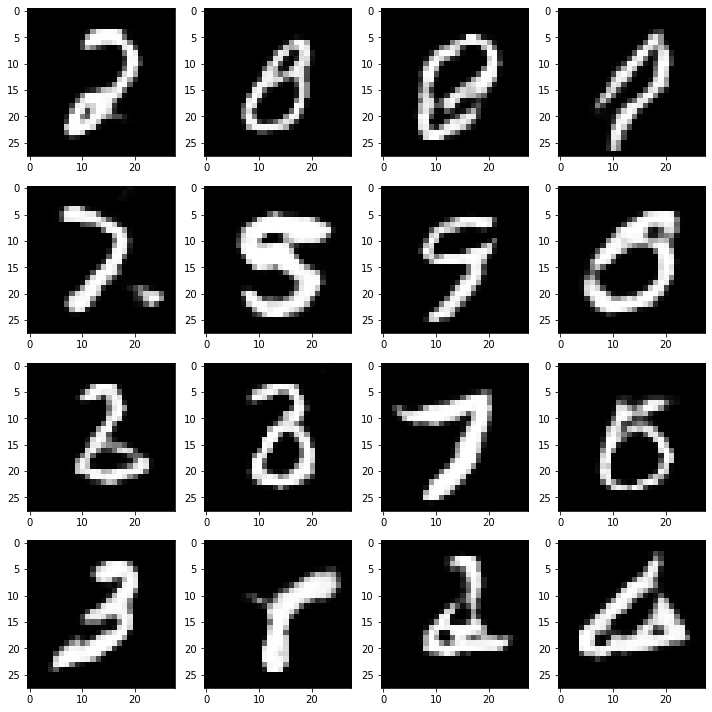

Epoch: 316
Generator Loss: 0.9443057775497437
Discriminator Loss: 1.268235206604004
Time for epoch 316 is 14.72362470626831 sec
Epoch: 317
Generator Loss: 0.855853796005249
Discriminator Loss: 1.2573626041412354
Time for epoch 317 is 14.704456090927124 sec
Epoch: 318
Generator Loss: 0.8627188205718994
Discriminator Loss: 1.2490832805633545
Time for epoch 318 is 14.639329195022583 sec
Epoch: 319
Generator Loss: 0.9259921908378601
Discriminator Loss: 1.2437454462051392
Time for epoch 319 is 14.654213190078735 sec
Epoch: 320
Generator Loss: 0.8916639685630798
Discriminator Loss: 1.2549974918365479
Time for epoch 320 is 14.663939476013184 sec
Epoch: 321
Generator Loss: 0.801411509513855
Discriminator Loss: 1.3767690658569336
Time for epoch 321 is 14.640876770019531 sec
Epoch: 322
Generator Loss: 0.8476348519325256
Discriminator Loss: 1.3102757930755615
Time for epoch 322 is 14.657880306243896 sec
Epoch: 323
Generator Loss: 0.7937706708908081
Discriminator Loss: 1.2954795360565186
Time for 

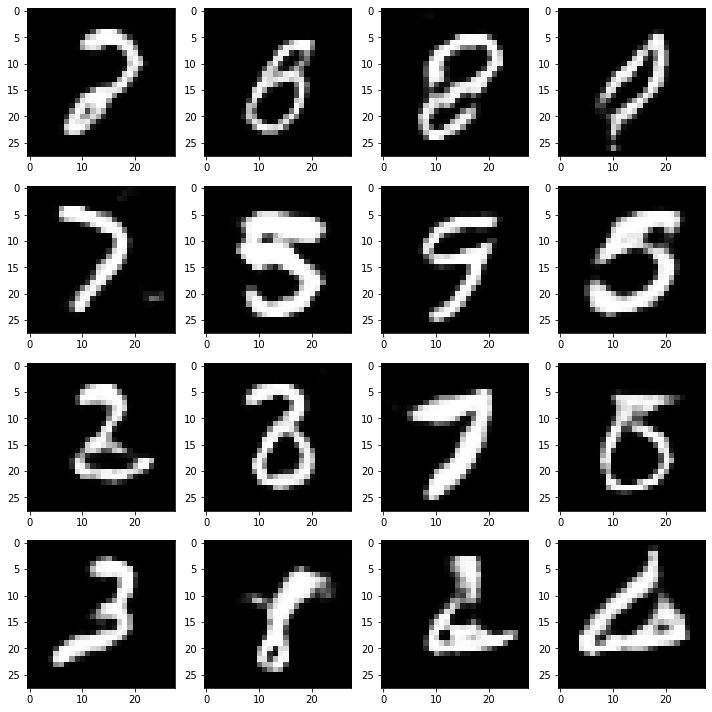

Epoch: 331
Generator Loss: 0.830757200717926
Discriminator Loss: 1.2607758045196533
Time for epoch 331 is 14.883911848068237 sec
Epoch: 332
Generator Loss: 0.8105822801589966
Discriminator Loss: 1.357061743736267
Time for epoch 332 is 14.657821893692017 sec
Epoch: 333
Generator Loss: 0.9300278425216675
Discriminator Loss: 1.2848721742630005
Time for epoch 333 is 14.67110562324524 sec
Epoch: 334
Generator Loss: 0.8918151259422302
Discriminator Loss: 1.3698146343231201
Time for epoch 334 is 14.649700403213501 sec
Epoch: 335
Generator Loss: 0.8590994477272034
Discriminator Loss: 1.2159388065338135
Time for epoch 335 is 14.668736219406128 sec
Epoch: 336
Generator Loss: 0.6382629871368408
Discriminator Loss: 1.4484944343566895
Time for epoch 336 is 14.683952808380127 sec
Epoch: 337
Generator Loss: 0.8998286724090576
Discriminator Loss: 1.1981797218322754
Time for epoch 337 is 14.656333208084106 sec
Epoch: 338
Generator Loss: 0.8849468231201172
Discriminator Loss: 1.187696099281311
Time for 

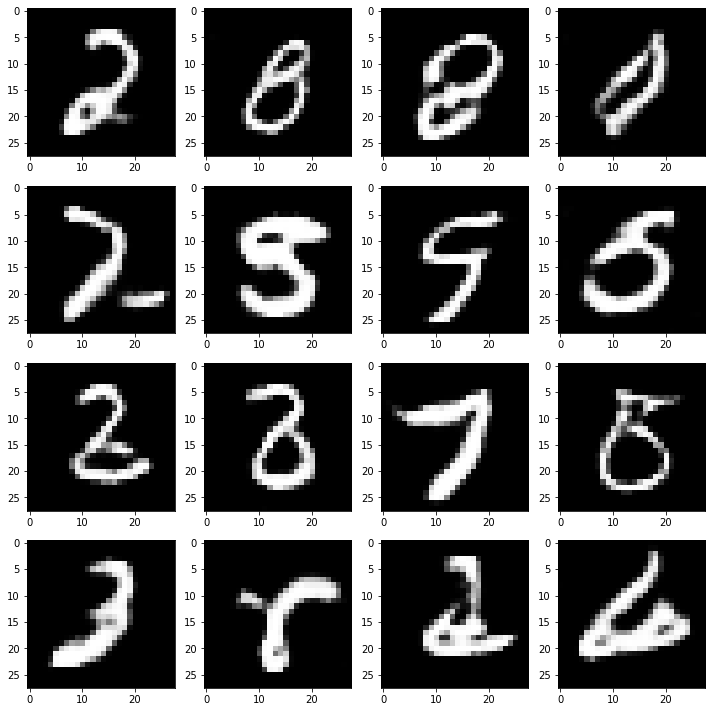

Epoch: 346
Generator Loss: 0.8694905638694763
Discriminator Loss: 1.285621166229248
Time for epoch 346 is 14.839674234390259 sec
Epoch: 347
Generator Loss: 0.8291739225387573
Discriminator Loss: 1.2474370002746582
Time for epoch 347 is 14.642210006713867 sec
Epoch: 348
Generator Loss: 0.9173521399497986
Discriminator Loss: 1.3876259326934814
Time for epoch 348 is 14.68793797492981 sec
Epoch: 349
Generator Loss: 0.9305175542831421
Discriminator Loss: 1.2169744968414307
Time for epoch 349 is 14.663597583770752 sec
Epoch: 350
Generator Loss: 0.8210175037384033
Discriminator Loss: 1.3167048692703247
Time for epoch 350 is 14.685589075088501 sec
Epoch: 351
Generator Loss: 0.8558021783828735
Discriminator Loss: 1.2761727571487427
Time for epoch 351 is 14.677814722061157 sec
Epoch: 352
Generator Loss: 0.8687422275543213
Discriminator Loss: 1.3102997541427612
Time for epoch 352 is 14.666324377059937 sec
Epoch: 353
Generator Loss: 0.7939174175262451
Discriminator Loss: 1.3122875690460205
Time fo

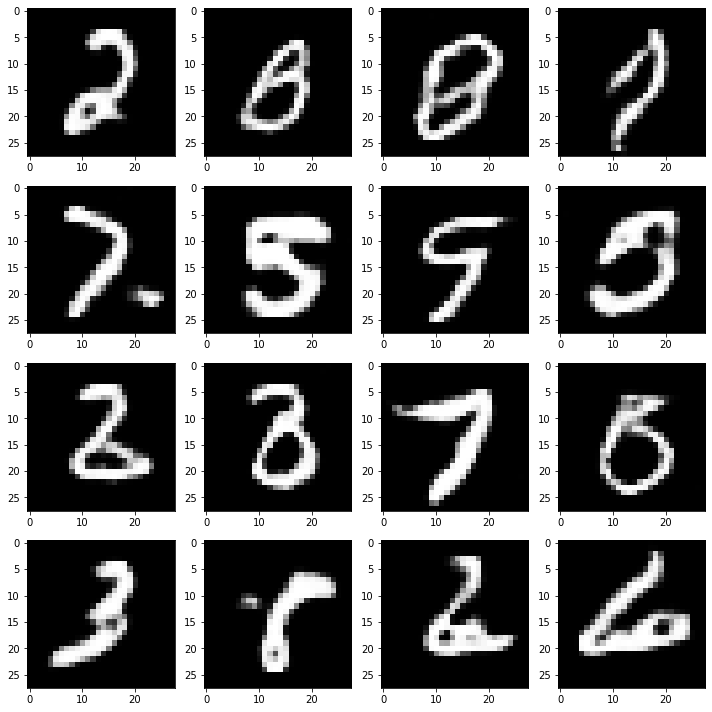

Epoch: 361
Generator Loss: 0.8780158162117004
Discriminator Loss: 1.3156726360321045
Time for epoch 361 is 14.817671060562134 sec
Epoch: 362
Generator Loss: 0.917113721370697
Discriminator Loss: 1.2828807830810547
Time for epoch 362 is 14.754753351211548 sec
Epoch: 363
Generator Loss: 0.8769499659538269
Discriminator Loss: 1.2654781341552734
Time for epoch 363 is 14.6249418258667 sec
Epoch: 364
Generator Loss: 0.7890578508377075
Discriminator Loss: 1.2741434574127197
Time for epoch 364 is 14.649213075637817 sec
Epoch: 365
Generator Loss: 0.8284914493560791
Discriminator Loss: 1.2798547744750977
Time for epoch 365 is 14.64385199546814 sec
Epoch: 366
Generator Loss: 0.8768386244773865
Discriminator Loss: 1.3224066495895386
Time for epoch 366 is 14.649673461914062 sec
Epoch: 367
Generator Loss: 0.8297747373580933
Discriminator Loss: 1.3310941457748413
Time for epoch 367 is 14.634095907211304 sec
Epoch: 368
Generator Loss: 0.8422691822052002
Discriminator Loss: 1.2251060009002686
Time for 

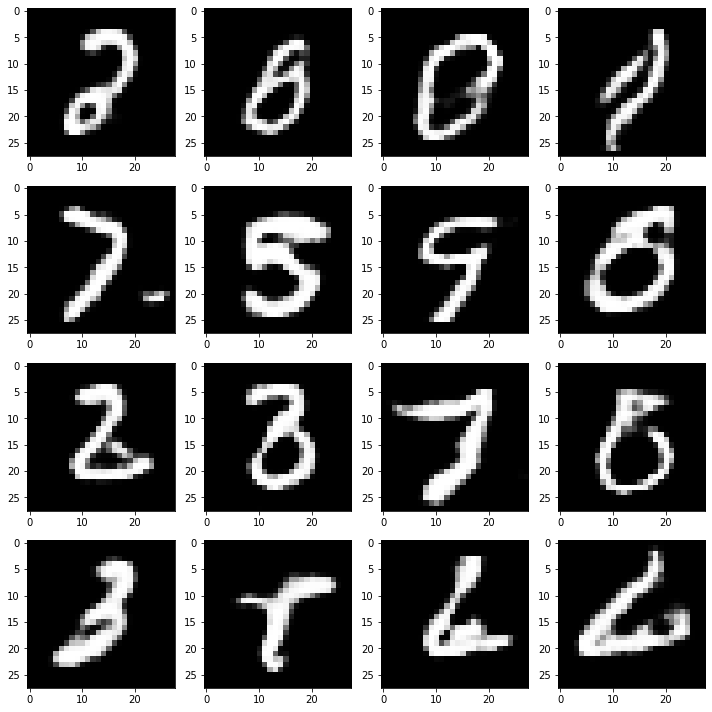

Epoch: 376
Generator Loss: 0.9108191728591919
Discriminator Loss: 1.2990598678588867
Time for epoch 376 is 14.70341420173645 sec
Epoch: 377
Generator Loss: 0.7823410034179688
Discriminator Loss: 1.3677544593811035
Time for epoch 377 is 14.669715642929077 sec
Epoch: 378
Generator Loss: 0.9286817312240601
Discriminator Loss: 1.3175044059753418
Time for epoch 378 is 14.663654565811157 sec
Epoch: 379
Generator Loss: 0.7765219211578369
Discriminator Loss: 1.3258099555969238
Time for epoch 379 is 14.661677837371826 sec
Epoch: 380
Generator Loss: 0.841923177242279
Discriminator Loss: 1.2370271682739258
Time for epoch 380 is 14.675806522369385 sec
Epoch: 381
Generator Loss: 0.8826540112495422
Discriminator Loss: 1.2056117057800293
Time for epoch 381 is 14.654211282730103 sec
Epoch: 382
Generator Loss: 0.9552367329597473
Discriminator Loss: 1.2084827423095703
Time for epoch 382 is 14.681879043579102 sec
Epoch: 383
Generator Loss: 0.7848407626152039
Discriminator Loss: 1.3549528121948242
Time fo

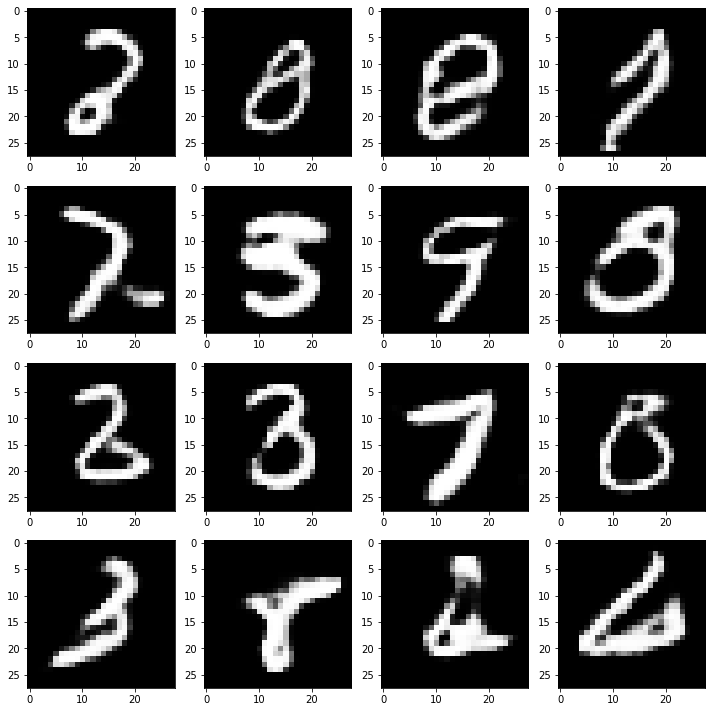

Epoch: 391
Generator Loss: 0.8754653930664062
Discriminator Loss: 1.3442277908325195
Time for epoch 391 is 14.918000936508179 sec
Epoch: 392
Generator Loss: 0.8830353617668152
Discriminator Loss: 1.2694768905639648
Time for epoch 392 is 14.699118614196777 sec
Epoch: 393
Generator Loss: 1.042158603668213
Discriminator Loss: 1.2597222328186035
Time for epoch 393 is 14.66944169998169 sec
Epoch: 394
Generator Loss: 0.8684641718864441
Discriminator Loss: 1.2810239791870117
Time for epoch 394 is 14.68868112564087 sec
Epoch: 395
Generator Loss: 0.844132125377655
Discriminator Loss: 1.2821159362792969
Time for epoch 395 is 14.699307203292847 sec
Epoch: 396
Generator Loss: 0.8791106939315796
Discriminator Loss: 1.3023104667663574
Time for epoch 396 is 14.682222604751587 sec
Epoch: 397
Generator Loss: 0.9075343608856201
Discriminator Loss: 1.271169662475586
Time for epoch 397 is 14.699607372283936 sec
Epoch: 398
Generator Loss: 0.8740006685256958
Discriminator Loss: 1.264802098274231
Time for ep

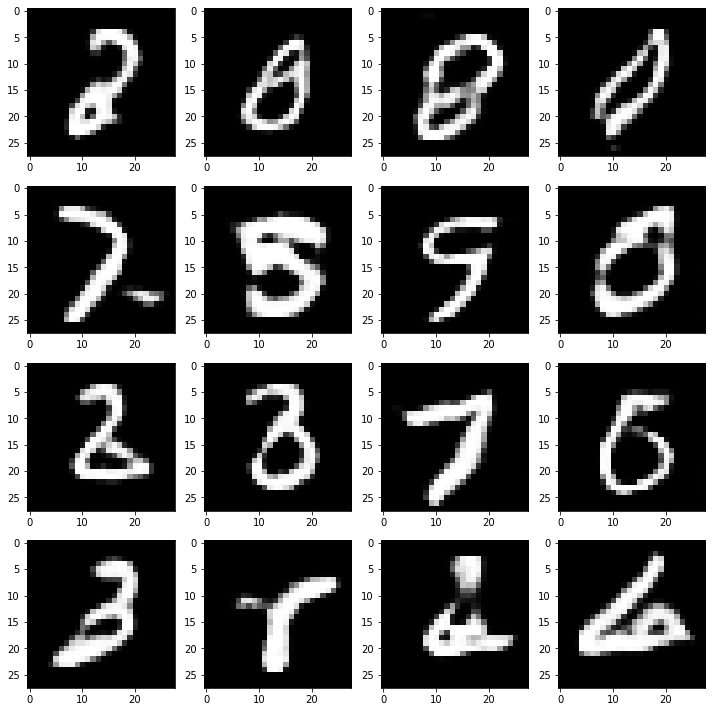

Epoch: 406
Generator Loss: 0.8256746530532837
Discriminator Loss: 1.3189302682876587
Time for epoch 406 is 14.853978395462036 sec
Epoch: 407
Generator Loss: 0.8143018484115601
Discriminator Loss: 1.2529051303863525
Time for epoch 407 is 14.67482876777649 sec
Epoch: 408
Generator Loss: 0.8600480556488037
Discriminator Loss: 1.2846941947937012
Time for epoch 408 is 14.675909996032715 sec
Epoch: 409
Generator Loss: 0.818553626537323
Discriminator Loss: 1.3327410221099854
Time for epoch 409 is 14.65640139579773 sec
Epoch: 410
Generator Loss: 0.8546026945114136
Discriminator Loss: 1.2350192070007324
Time for epoch 410 is 14.648977041244507 sec
Epoch: 411
Generator Loss: 0.8664875626564026
Discriminator Loss: 1.2859536409378052
Time for epoch 411 is 14.676315069198608 sec
Epoch: 412
Generator Loss: 0.7905704975128174
Discriminator Loss: 1.3374354839324951
Time for epoch 412 is 14.637045860290527 sec
Epoch: 413
Generator Loss: 0.8388736248016357
Discriminator Loss: 1.2547802925109863
Time for

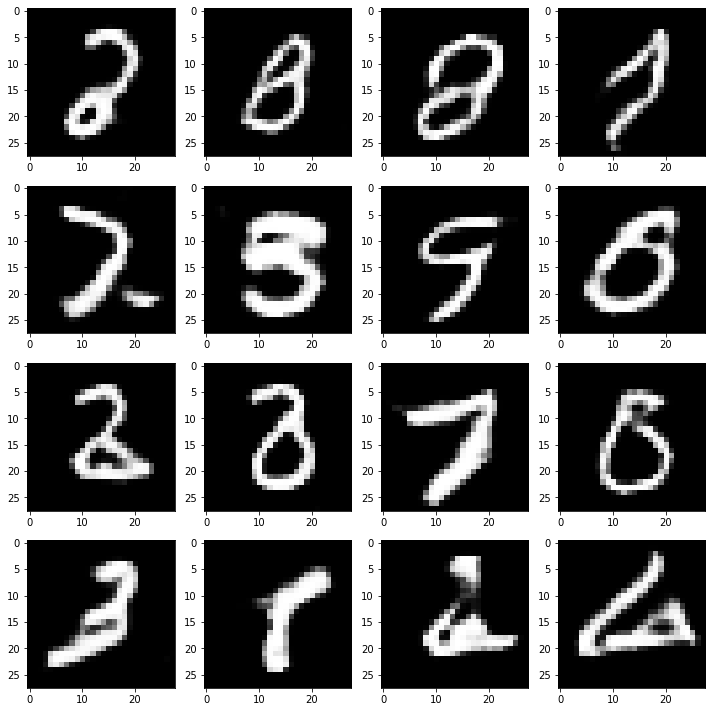

Epoch: 421
Generator Loss: 0.8375771641731262
Discriminator Loss: 1.3025813102722168
Time for epoch 421 is 14.866572856903076 sec
Epoch: 422
Generator Loss: 0.8291711211204529
Discriminator Loss: 1.3354463577270508
Time for epoch 422 is 14.690885305404663 sec
Epoch: 423
Generator Loss: 0.8596014976501465
Discriminator Loss: 1.3922319412231445
Time for epoch 423 is 14.658642768859863 sec
Epoch: 424
Generator Loss: 0.9724121689796448
Discriminator Loss: 1.270554780960083
Time for epoch 424 is 14.663801431655884 sec
Epoch: 425
Generator Loss: 0.839693546295166
Discriminator Loss: 1.2685637474060059
Time for epoch 425 is 14.678630113601685 sec
Epoch: 426
Generator Loss: 1.0115184783935547
Discriminator Loss: 1.2096712589263916
Time for epoch 426 is 14.677229881286621 sec
Epoch: 427
Generator Loss: 0.8472397327423096
Discriminator Loss: 1.321049451828003
Time for epoch 427 is 14.675991296768188 sec
Epoch: 428
Generator Loss: 0.8769677877426147
Discriminator Loss: 1.2452647686004639
Time for

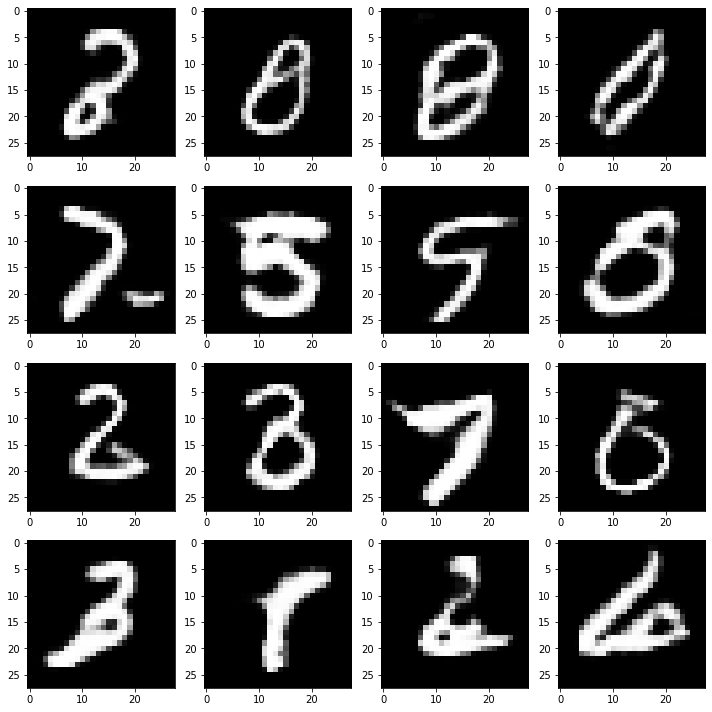

Epoch: 436
Generator Loss: 0.8826854228973389
Discriminator Loss: 1.3375520706176758
Time for epoch 436 is 14.748618841171265 sec
Epoch: 437
Generator Loss: 0.9692413806915283
Discriminator Loss: 1.2470893859863281
Time for epoch 437 is 14.659111738204956 sec
Epoch: 438
Generator Loss: 0.8168096542358398
Discriminator Loss: 1.3554565906524658
Time for epoch 438 is 14.693748235702515 sec
Epoch: 439
Generator Loss: 0.964255690574646
Discriminator Loss: 1.3052089214324951
Time for epoch 439 is 14.672801971435547 sec
Epoch: 440
Generator Loss: 0.8711725473403931
Discriminator Loss: 1.2924907207489014
Time for epoch 440 is 14.689477920532227 sec
Epoch: 441
Generator Loss: 0.8325895071029663
Discriminator Loss: 1.3395414352416992
Time for epoch 441 is 14.678900241851807 sec
Epoch: 442
Generator Loss: 0.9809950590133667
Discriminator Loss: 1.2101938724517822
Time for epoch 442 is 14.678930759429932 sec
Epoch: 443
Generator Loss: 0.8274579644203186
Discriminator Loss: 1.3081958293914795
Time f

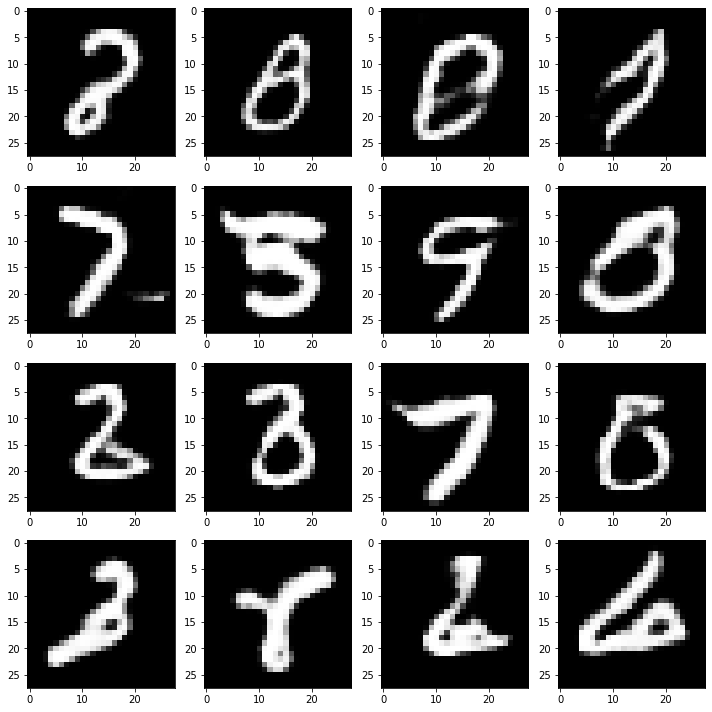

Epoch: 451
Generator Loss: 0.8672282695770264
Discriminator Loss: 1.2956831455230713
Time for epoch 451 is 14.850188493728638 sec
Epoch: 452
Generator Loss: 0.8987763524055481
Discriminator Loss: 1.360764503479004
Time for epoch 452 is 14.653982877731323 sec
Epoch: 453
Generator Loss: 0.8518033623695374
Discriminator Loss: 1.287811279296875
Time for epoch 453 is 14.682803630828857 sec
Epoch: 454
Generator Loss: 0.8630267977714539
Discriminator Loss: 1.48978590965271
Time for epoch 454 is 14.66535472869873 sec
Epoch: 455
Generator Loss: 0.7627261877059937
Discriminator Loss: 1.3145949840545654
Time for epoch 455 is 14.651102781295776 sec
Epoch: 456
Generator Loss: 0.8924061059951782
Discriminator Loss: 1.321022629737854
Time for epoch 456 is 14.712092876434326 sec
Epoch: 457
Generator Loss: 0.789023220539093
Discriminator Loss: 1.3665406703948975
Time for epoch 457 is 14.67195177078247 sec
Epoch: 458
Generator Loss: 0.8298982381820679
Discriminator Loss: 1.2400360107421875
Time for epoc

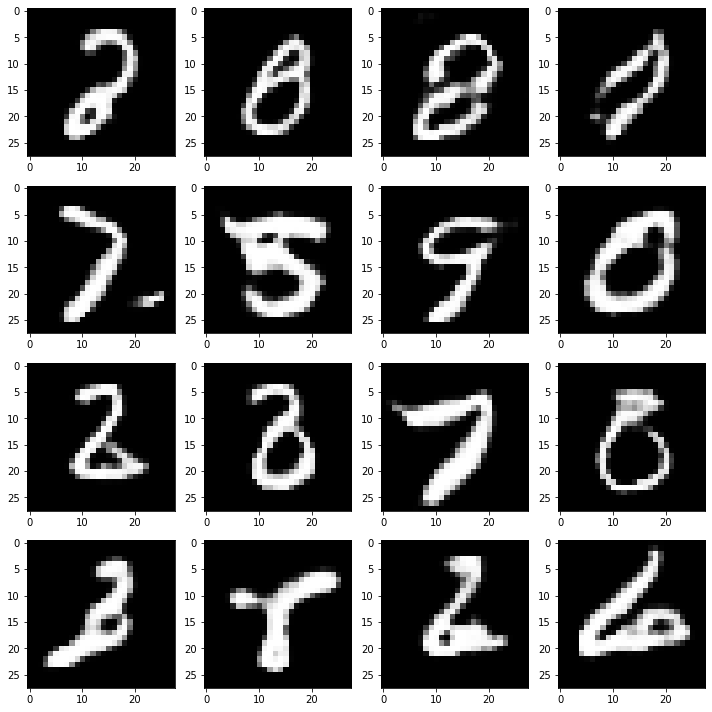

Epoch: 466
Generator Loss: 0.9078576564788818
Discriminator Loss: 1.2939410209655762
Time for epoch 466 is 14.737250328063965 sec
Epoch: 467
Generator Loss: 0.9861818552017212
Discriminator Loss: 1.2596917152404785
Time for epoch 467 is 14.658600330352783 sec
Epoch: 468
Generator Loss: 0.8282443881034851
Discriminator Loss: 1.3324674367904663
Time for epoch 468 is 14.694449186325073 sec
Epoch: 469
Generator Loss: 0.8680808544158936
Discriminator Loss: 1.2974095344543457
Time for epoch 469 is 14.635759353637695 sec
Epoch: 470
Generator Loss: 0.9232118725776672
Discriminator Loss: 1.3028874397277832
Time for epoch 470 is 14.653301477432251 sec
Epoch: 471
Generator Loss: 0.8440706133842468
Discriminator Loss: 1.2740498781204224
Time for epoch 471 is 14.68700885772705 sec
Epoch: 472
Generator Loss: 0.8165377378463745
Discriminator Loss: 1.2783753871917725
Time for epoch 472 is 14.702011823654175 sec
Epoch: 473
Generator Loss: 0.7960531115531921
Discriminator Loss: 1.266474723815918
Time fo

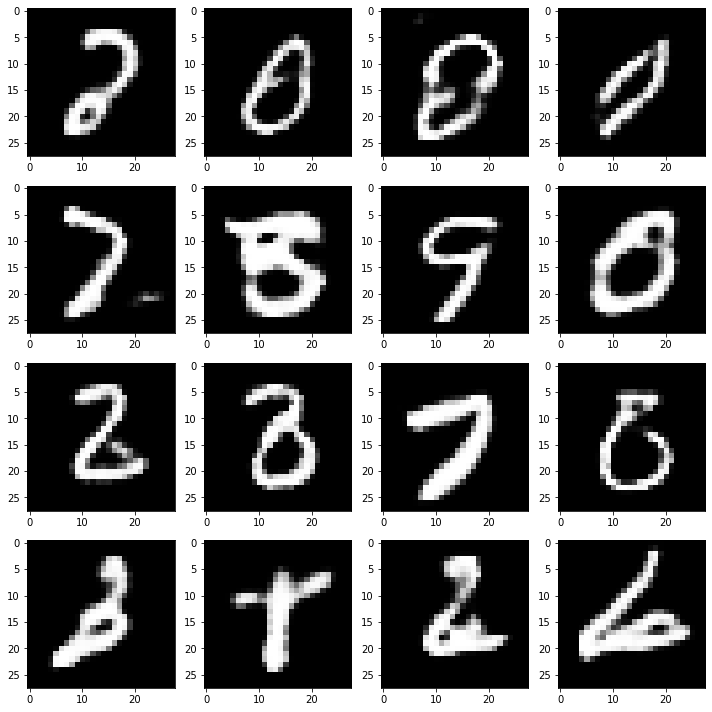

Epoch: 481
Generator Loss: 0.8642781376838684
Discriminator Loss: 1.2756710052490234
Time for epoch 481 is 14.791232585906982 sec
Epoch: 482
Generator Loss: 0.7938404083251953
Discriminator Loss: 1.3380835056304932
Time for epoch 482 is 14.680388450622559 sec
Epoch: 483
Generator Loss: 0.8810299634933472
Discriminator Loss: 1.2959249019622803
Time for epoch 483 is 14.665037631988525 sec
Epoch: 484
Generator Loss: 0.94305020570755
Discriminator Loss: 1.2017338275909424
Time for epoch 484 is 14.669512271881104 sec
Epoch: 485
Generator Loss: 0.8202309608459473
Discriminator Loss: 1.2988567352294922
Time for epoch 485 is 14.630229473114014 sec
Epoch: 486
Generator Loss: 0.832587718963623
Discriminator Loss: 1.3185558319091797
Time for epoch 486 is 14.660406112670898 sec
Epoch: 487
Generator Loss: 0.898842453956604
Discriminator Loss: 1.4148485660552979
Time for epoch 487 is 14.678431034088135 sec
Epoch: 488
Generator Loss: 0.9386156797409058
Discriminator Loss: 1.2277756929397583
Time for 

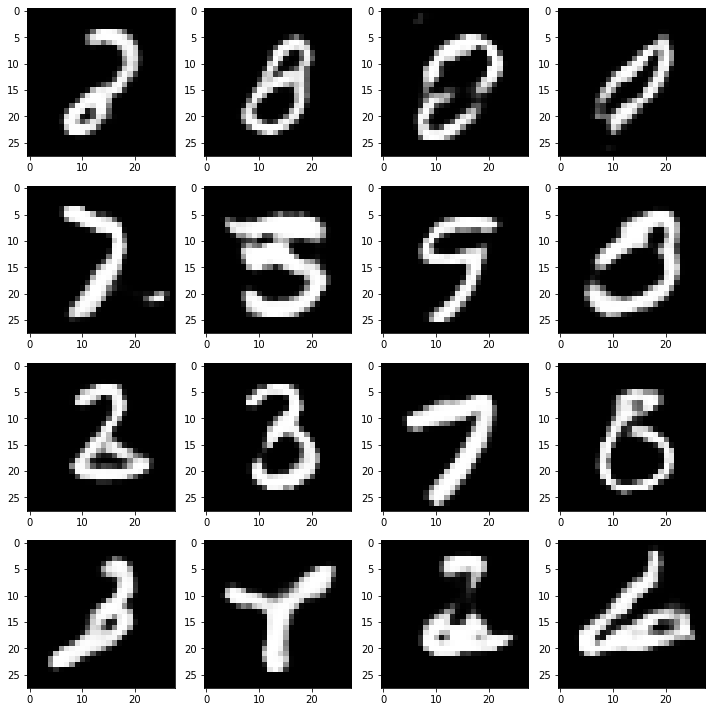

Epoch: 496
Generator Loss: 0.8203614950180054
Discriminator Loss: 1.3183894157409668
Time for epoch 496 is 14.806768417358398 sec
Epoch: 497
Generator Loss: 0.8107821941375732
Discriminator Loss: 1.310770034790039
Time for epoch 497 is 14.703613996505737 sec
Epoch: 498
Generator Loss: 0.7442654967308044
Discriminator Loss: 1.3423986434936523
Time for epoch 498 is 14.679993629455566 sec
Epoch: 499
Generator Loss: 0.8294122219085693
Discriminator Loss: 1.2816100120544434
Time for epoch 499 is 14.655709981918335 sec
Epoch: 500
Generator Loss: 0.9142443537712097
Discriminator Loss: 1.2584151029586792
Time for epoch 500 is 14.64159607887268 sec
Epoch: 501
Generator Loss: 0.8277300596237183
Discriminator Loss: 1.2632982730865479
Time for epoch 501 is 14.625777959823608 sec
Epoch: 502
Generator Loss: 0.8947799205780029
Discriminator Loss: 1.260441541671753
Time for epoch 502 is 14.651346445083618 sec
Epoch: 503
Generator Loss: 0.8758066892623901
Discriminator Loss: 1.4039671421051025
Time for

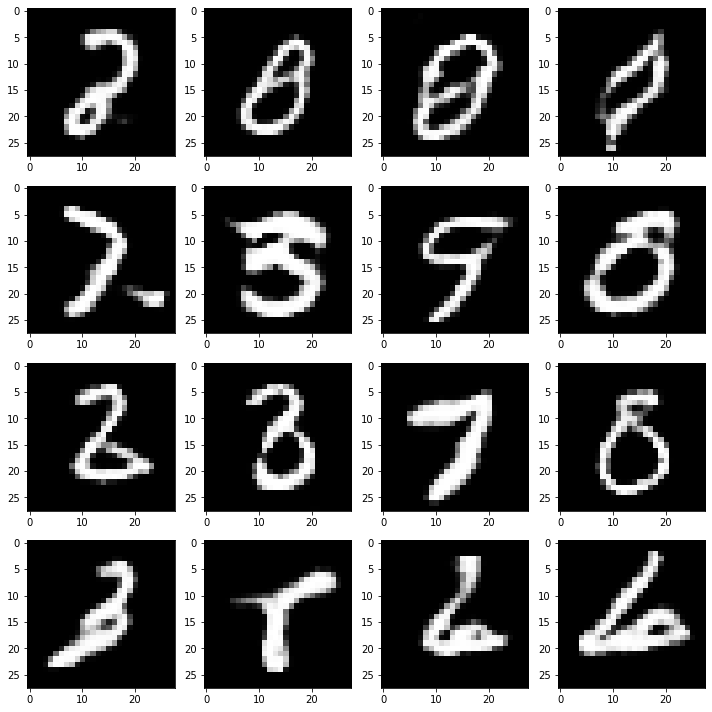

Epoch: 511
Generator Loss: 0.7991315722465515
Discriminator Loss: 1.3475648164749146
Time for epoch 511 is 14.769678115844727 sec
Epoch: 512
Generator Loss: 0.8556216955184937
Discriminator Loss: 1.3468800783157349
Time for epoch 512 is 14.700140237808228 sec
Epoch: 513
Generator Loss: 0.8823701739311218
Discriminator Loss: 1.2662169933319092
Time for epoch 513 is 15.156774520874023 sec
Epoch: 514
Generator Loss: 0.7864517569541931
Discriminator Loss: 1.294741153717041
Time for epoch 514 is 14.890422344207764 sec
Epoch: 515
Generator Loss: 0.8594173192977905
Discriminator Loss: 1.2127634286880493
Time for epoch 515 is 14.669852256774902 sec
Epoch: 516
Generator Loss: 0.8710874319076538
Discriminator Loss: 1.240882158279419
Time for epoch 516 is 14.679450750350952 sec
Epoch: 517
Generator Loss: 0.9839167594909668
Discriminator Loss: 1.2429726123809814
Time for epoch 517 is 14.687631845474243 sec
Epoch: 518
Generator Loss: 0.8145838379859924
Discriminator Loss: 1.3624391555786133
Time fo

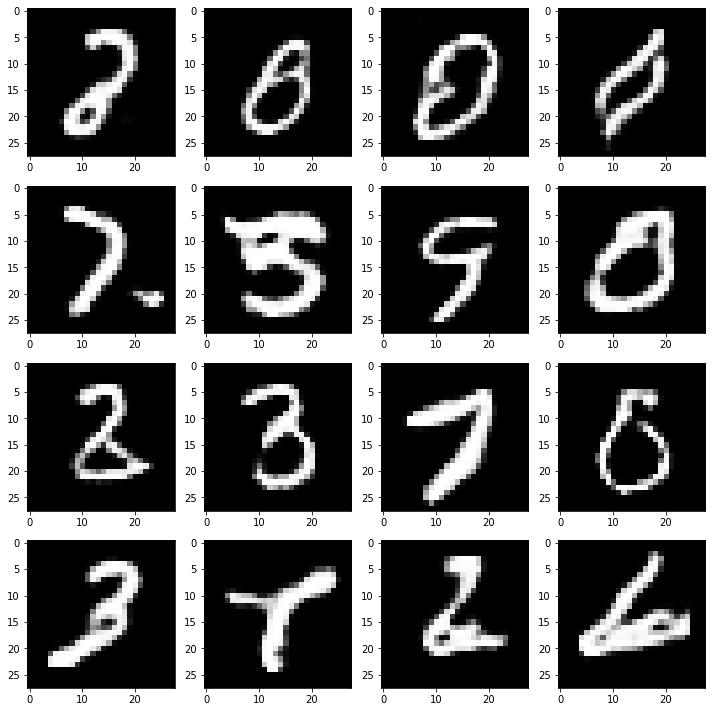

Epoch: 526
Generator Loss: 0.9030047059059143
Discriminator Loss: 1.2792410850524902
Time for epoch 526 is 14.883584022521973 sec
Epoch: 527
Generator Loss: 0.8972629308700562
Discriminator Loss: 1.267996907234192
Time for epoch 527 is 14.667108058929443 sec
Epoch: 528
Generator Loss: 0.8534637689590454
Discriminator Loss: 1.3064756393432617
Time for epoch 528 is 14.75541877746582 sec
Epoch: 529
Generator Loss: 0.7795737981796265
Discriminator Loss: 1.454242467880249
Time for epoch 529 is 14.708359003067017 sec
Epoch: 530
Generator Loss: 0.8767356276512146
Discriminator Loss: 1.3551208972930908
Time for epoch 530 is 14.670597553253174 sec
Epoch: 531
Generator Loss: 0.9567317962646484
Discriminator Loss: 1.2481677532196045
Time for epoch 531 is 14.662872552871704 sec
Epoch: 532
Generator Loss: 0.8539364337921143
Discriminator Loss: 1.1996960639953613
Time for epoch 532 is 14.657348155975342 sec
Epoch: 533
Generator Loss: 0.8374502062797546
Discriminator Loss: 1.34372878074646
Time for e

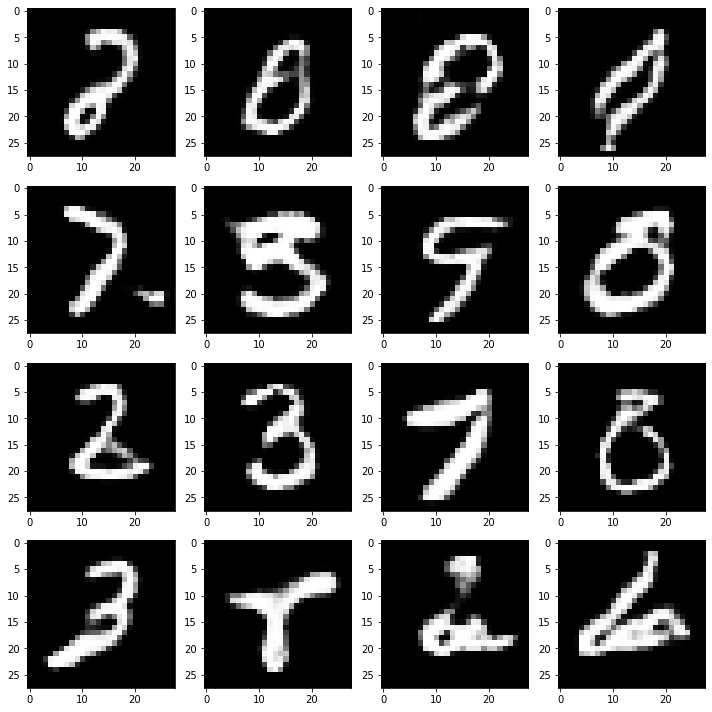

Epoch: 541
Generator Loss: 0.8680042028427124
Discriminator Loss: 1.2611677646636963
Time for epoch 541 is 14.885891437530518 sec
Epoch: 542
Generator Loss: 0.7650457620620728
Discriminator Loss: 1.3432332277297974
Time for epoch 542 is 14.641791582107544 sec
Epoch: 543
Generator Loss: 0.9400774240493774
Discriminator Loss: 1.2509984970092773
Time for epoch 543 is 14.705371379852295 sec
Epoch: 544
Generator Loss: 0.8788217306137085
Discriminator Loss: 1.2575069665908813
Time for epoch 544 is 14.686970233917236 sec
Epoch: 545
Generator Loss: 0.862543523311615
Discriminator Loss: 1.1727206707000732
Time for epoch 545 is 14.704631328582764 sec
Epoch: 546
Generator Loss: 0.8948405981063843
Discriminator Loss: 1.215073585510254
Time for epoch 546 is 14.6527419090271 sec
Epoch: 547
Generator Loss: 0.9578065872192383
Discriminator Loss: 1.2524113655090332
Time for epoch 547 is 14.657495260238647 sec
Epoch: 548
Generator Loss: 0.9310176372528076
Discriminator Loss: 1.2926597595214844
Time for 

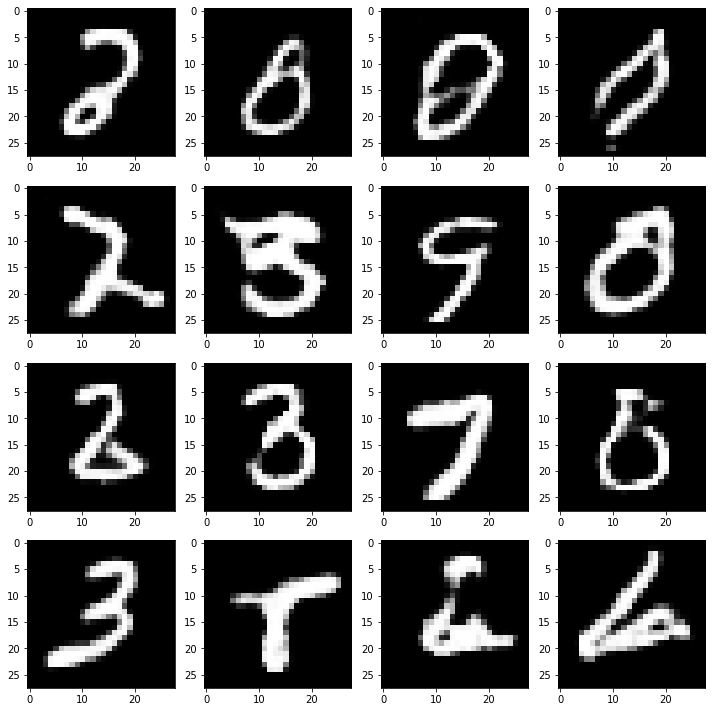

Epoch: 556
Generator Loss: 0.8379148244857788
Discriminator Loss: 1.3062381744384766
Time for epoch 556 is 14.831883907318115 sec
Epoch: 557
Generator Loss: 0.7979134321212769
Discriminator Loss: 1.3248040676116943
Time for epoch 557 is 14.647404670715332 sec
Epoch: 558
Generator Loss: 0.8729326128959656
Discriminator Loss: 1.2877799272537231
Time for epoch 558 is 14.668531656265259 sec
Epoch: 559
Generator Loss: 0.8362575173377991
Discriminator Loss: 1.4165030717849731
Time for epoch 559 is 14.673747062683105 sec
Epoch: 560
Generator Loss: 0.8351337313652039
Discriminator Loss: 1.2711822986602783
Time for epoch 560 is 14.674695253372192 sec
Epoch: 561
Generator Loss: 0.8496624231338501
Discriminator Loss: 1.2686835527420044
Time for epoch 561 is 14.629157304763794 sec
Epoch: 562
Generator Loss: 0.883804202079773
Discriminator Loss: 1.2924373149871826
Time for epoch 562 is 14.674633979797363 sec
Epoch: 563
Generator Loss: 0.9345343708992004
Discriminator Loss: 1.218045949935913
Time fo

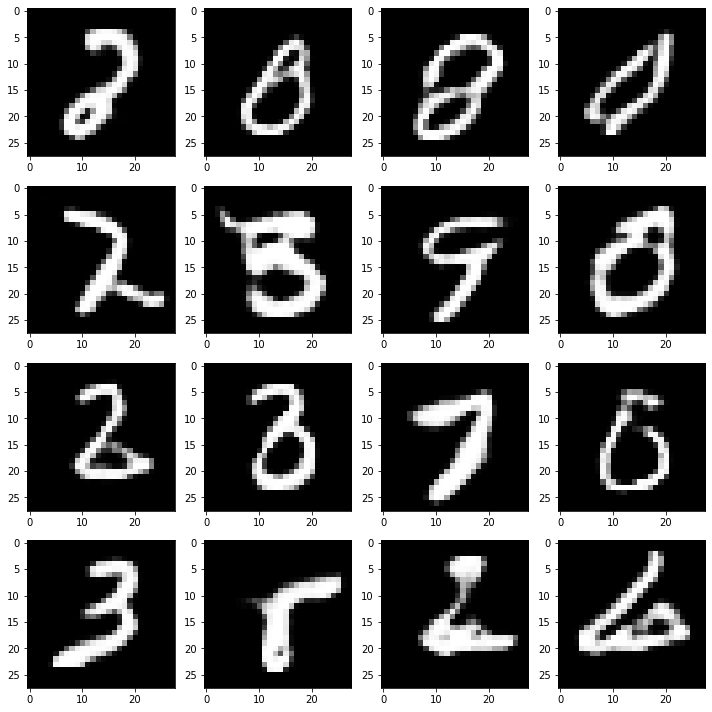

Epoch: 571
Generator Loss: 0.9086382389068604
Discriminator Loss: 1.227097749710083
Time for epoch 571 is 14.839596033096313 sec
Epoch: 572
Generator Loss: 0.8521156311035156
Discriminator Loss: 1.317748785018921
Time for epoch 572 is 14.691895961761475 sec
Epoch: 573
Generator Loss: 0.8680662512779236
Discriminator Loss: 1.3118700981140137
Time for epoch 573 is 14.678531646728516 sec
Epoch: 574
Generator Loss: 0.87935870885849
Discriminator Loss: 1.297886848449707
Time for epoch 574 is 14.710352420806885 sec
Epoch: 575
Generator Loss: 0.8436554670333862
Discriminator Loss: 1.298891305923462
Time for epoch 575 is 14.670342922210693 sec
Epoch: 576
Generator Loss: 0.9367420673370361
Discriminator Loss: 1.361025094985962
Time for epoch 576 is 14.686527252197266 sec
Epoch: 577
Generator Loss: 0.8444646596908569
Discriminator Loss: 1.2601501941680908
Time for epoch 577 is 14.662612199783325 sec
Epoch: 578
Generator Loss: 0.7974421381950378
Discriminator Loss: 1.3839720487594604
Time for epo

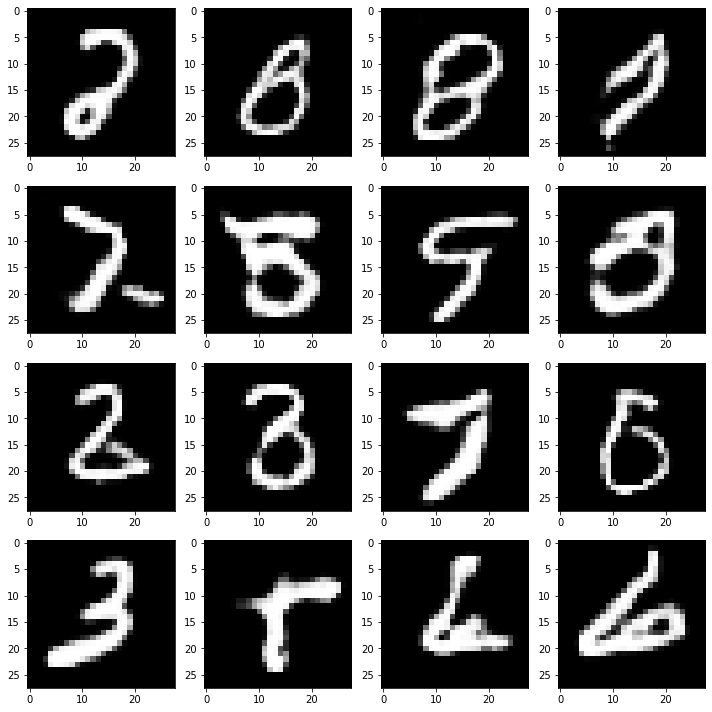

Epoch: 586
Generator Loss: 0.8533726930618286
Discriminator Loss: 1.2809412479400635
Time for epoch 586 is 14.76233959197998 sec
Epoch: 587
Generator Loss: 0.8234753608703613
Discriminator Loss: 1.3352947235107422
Time for epoch 587 is 14.706310749053955 sec
Epoch: 588
Generator Loss: 0.7972632646560669
Discriminator Loss: 1.2759466171264648
Time for epoch 588 is 14.663117408752441 sec
Epoch: 589
Generator Loss: 0.918979823589325
Discriminator Loss: 1.2710065841674805
Time for epoch 589 is 14.696914911270142 sec
Epoch: 590
Generator Loss: 0.8610250949859619
Discriminator Loss: 1.4365631341934204
Time for epoch 590 is 14.666096210479736 sec
Epoch: 591
Generator Loss: 0.8498879075050354
Discriminator Loss: 1.2622945308685303
Time for epoch 591 is 14.673694372177124 sec
Epoch: 592
Generator Loss: 0.8430511355400085
Discriminator Loss: 1.2773364782333374
Time for epoch 592 is 14.676626682281494 sec
Epoch: 593
Generator Loss: 0.8369274735450745
Discriminator Loss: 1.3626291751861572
Time fo

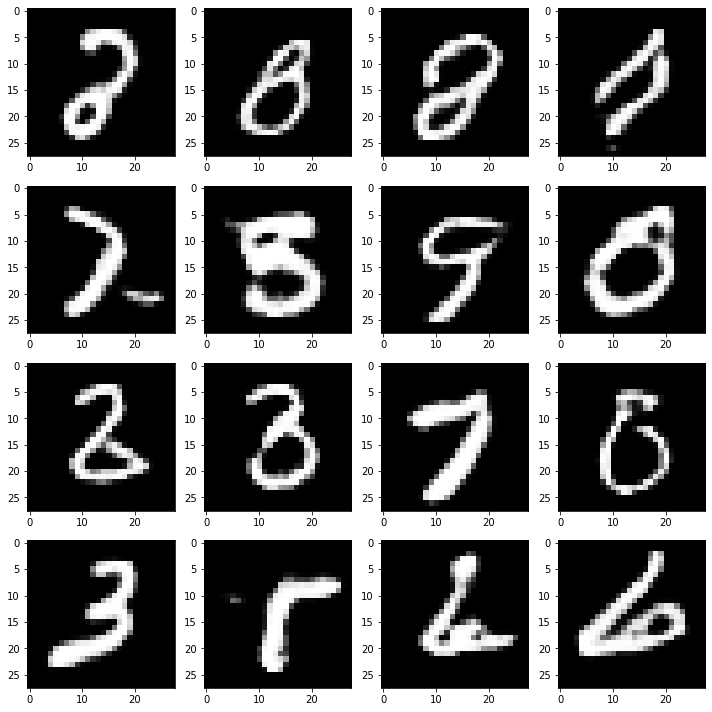

Epoch: 601
Generator Loss: 0.7369360327720642
Discriminator Loss: 1.3369555473327637
Time for epoch 601 is 14.74788498878479 sec
Epoch: 602
Generator Loss: 0.8576002717018127
Discriminator Loss: 1.2488501071929932
Time for epoch 602 is 14.669921636581421 sec
Epoch: 603
Generator Loss: 0.8795702457427979
Discriminator Loss: 1.3499560356140137
Time for epoch 603 is 14.672815084457397 sec
Epoch: 604
Generator Loss: 0.8612436056137085
Discriminator Loss: 1.4025684595108032
Time for epoch 604 is 14.682060241699219 sec
Epoch: 605
Generator Loss: 0.9138540625572205
Discriminator Loss: 1.319051742553711
Time for epoch 605 is 14.689175367355347 sec
Epoch: 606
Generator Loss: 0.7699624300003052
Discriminator Loss: 1.377724528312683
Time for epoch 606 is 14.669665098190308 sec
Epoch: 607
Generator Loss: 0.818394660949707
Discriminator Loss: 1.269869089126587
Time for epoch 607 is 14.660091400146484 sec
Epoch: 608
Generator Loss: 0.858810305595398
Discriminator Loss: 1.2424089908599854
Time for ep

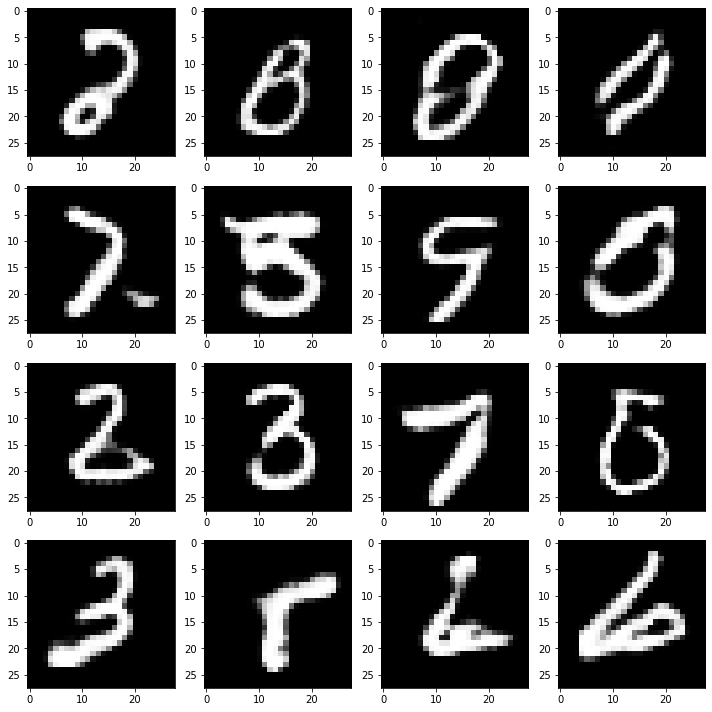

Epoch: 616
Generator Loss: 0.840945303440094
Discriminator Loss: 1.3006223440170288
Time for epoch 616 is 14.85717487335205 sec
Epoch: 617
Generator Loss: 0.879414975643158
Discriminator Loss: 1.2285809516906738
Time for epoch 617 is 14.678369998931885 sec
Epoch: 618
Generator Loss: 0.8581329584121704
Discriminator Loss: 1.2388279438018799
Time for epoch 618 is 14.698387145996094 sec
Epoch: 619
Generator Loss: 0.8714743852615356
Discriminator Loss: 1.2877405881881714
Time for epoch 619 is 14.620934247970581 sec
Epoch: 620
Generator Loss: 0.8987468481063843
Discriminator Loss: 1.2974478006362915
Time for epoch 620 is 14.664561986923218 sec
Epoch: 621
Generator Loss: 0.9163008332252502
Discriminator Loss: 1.3013126850128174
Time for epoch 621 is 14.691065549850464 sec
Epoch: 622
Generator Loss: 0.7671211361885071
Discriminator Loss: 1.4489418268203735
Time for epoch 622 is 14.863795280456543 sec
Epoch: 623
Generator Loss: 0.9501641988754272
Discriminator Loss: 1.2333121299743652
Time for

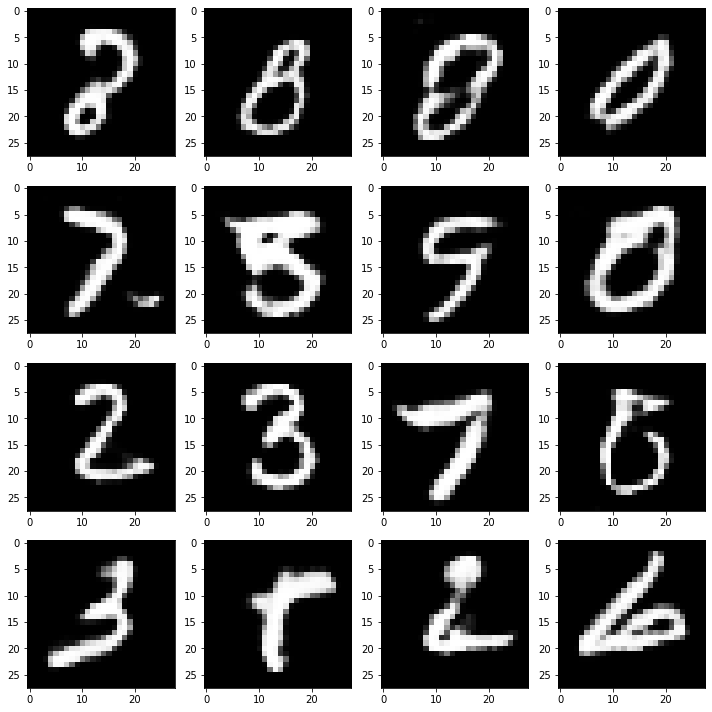

Epoch: 631
Generator Loss: 0.8785607218742371
Discriminator Loss: 1.281069278717041
Time for epoch 631 is 14.779701948165894 sec
Epoch: 632
Generator Loss: 0.7513471841812134
Discriminator Loss: 1.35489022731781
Time for epoch 632 is 14.693650722503662 sec
Epoch: 633
Generator Loss: 0.9288973808288574
Discriminator Loss: 1.2556428909301758
Time for epoch 633 is 14.640694379806519 sec
Epoch: 634
Generator Loss: 0.8368484377861023
Discriminator Loss: 1.273202657699585
Time for epoch 634 is 14.664948225021362 sec
Epoch: 635
Generator Loss: 0.8983922004699707
Discriminator Loss: 1.227675437927246
Time for epoch 635 is 14.626060962677002 sec
Epoch: 636
Generator Loss: 0.8034496307373047
Discriminator Loss: 1.318935513496399
Time for epoch 636 is 14.648455381393433 sec
Epoch: 637
Generator Loss: 0.8762845396995544
Discriminator Loss: 1.2985931634902954
Time for epoch 637 is 14.662863731384277 sec
Epoch: 638
Generator Loss: 0.8542099595069885
Discriminator Loss: 1.3581016063690186
Time for ep

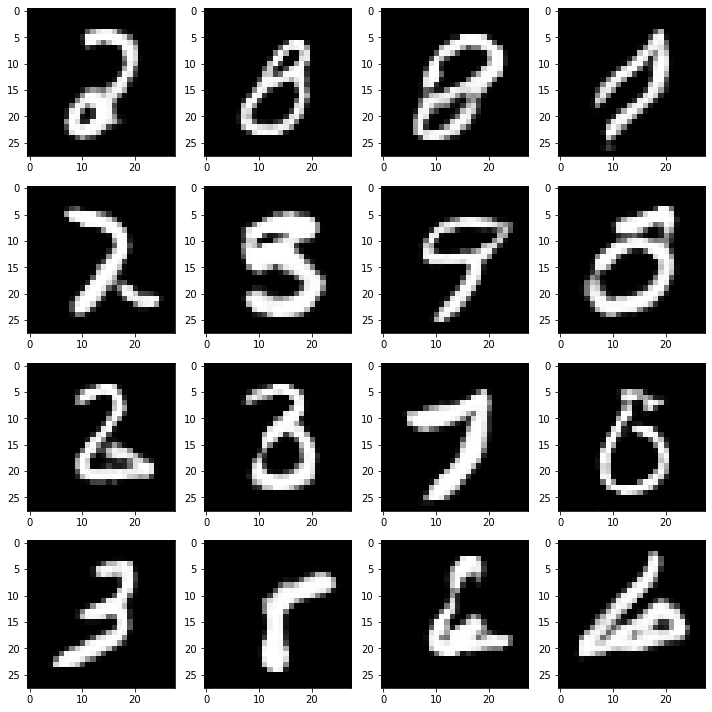

Epoch: 646
Generator Loss: 0.8971308469772339
Discriminator Loss: 1.3319591283798218
Time for epoch 646 is 14.839639663696289 sec
Epoch: 647
Generator Loss: 0.9283214807510376
Discriminator Loss: 1.233363151550293
Time for epoch 647 is 14.688886880874634 sec
Epoch: 648
Generator Loss: 0.8474128842353821
Discriminator Loss: 1.3189257383346558
Time for epoch 648 is 14.73922324180603 sec
Epoch: 649
Generator Loss: 0.8140010833740234
Discriminator Loss: 1.4130134582519531
Time for epoch 649 is 14.723305702209473 sec
Epoch: 650
Generator Loss: 0.8688621520996094
Discriminator Loss: 1.311617374420166
Time for epoch 650 is 14.685826778411865 sec
Epoch: 651
Generator Loss: 0.924648106098175
Discriminator Loss: 1.2446264028549194
Time for epoch 651 is 14.664920091629028 sec
Epoch: 652
Generator Loss: 0.8160489797592163
Discriminator Loss: 1.2941120862960815
Time for epoch 652 is 14.666095733642578 sec
Epoch: 653
Generator Loss: 0.843977689743042
Discriminator Loss: 1.2667236328125
Time for epoc

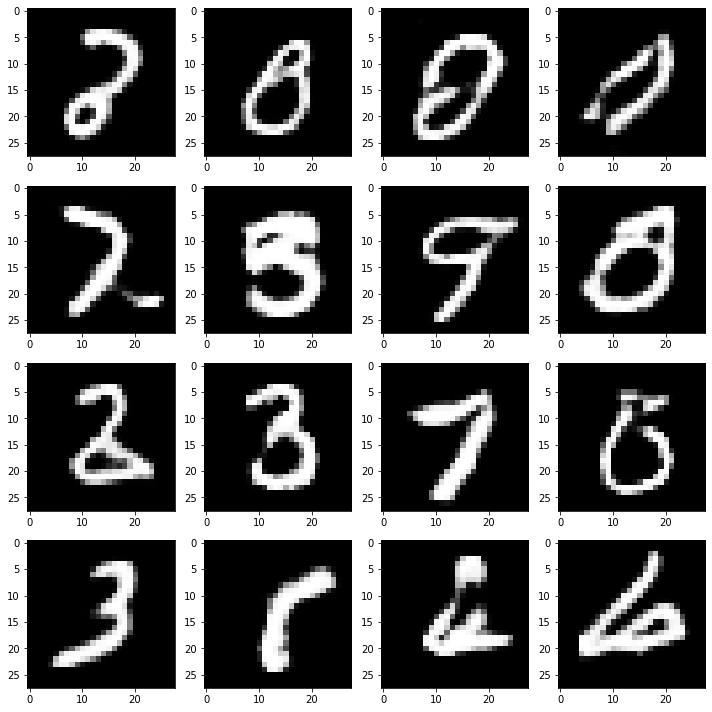

Epoch: 661
Generator Loss: 0.8483627438545227
Discriminator Loss: 1.2526986598968506
Time for epoch 661 is 14.877165794372559 sec
Epoch: 662
Generator Loss: 0.8370898962020874
Discriminator Loss: 1.2972593307495117
Time for epoch 662 is 14.663103580474854 sec
Epoch: 663
Generator Loss: 0.846218466758728
Discriminator Loss: 1.2341265678405762
Time for epoch 663 is 14.646121978759766 sec
Epoch: 664
Generator Loss: 0.881267786026001
Discriminator Loss: 1.2671750783920288
Time for epoch 664 is 14.643406629562378 sec
Epoch: 665
Generator Loss: 0.908970832824707
Discriminator Loss: 1.3242053985595703
Time for epoch 665 is 14.63907265663147 sec
Epoch: 666
Generator Loss: 0.8524207472801208
Discriminator Loss: 1.2746689319610596
Time for epoch 666 is 14.665638208389282 sec
Epoch: 667
Generator Loss: 0.8607885837554932
Discriminator Loss: 1.2641654014587402
Time for epoch 667 is 14.667993783950806 sec
Epoch: 668
Generator Loss: 0.8410331010818481
Discriminator Loss: 1.2434171438217163
Time for 

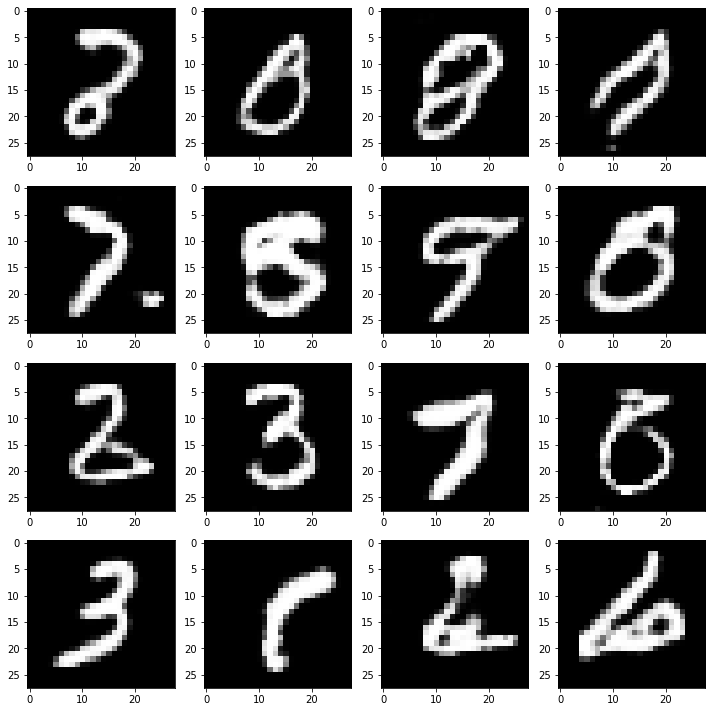

Epoch: 676
Generator Loss: 0.8402425050735474
Discriminator Loss: 1.2530211210250854
Time for epoch 676 is 14.711627960205078 sec
Epoch: 677
Generator Loss: 0.9043020009994507
Discriminator Loss: 1.1737711429595947
Time for epoch 677 is 14.746176481246948 sec
Epoch: 678
Generator Loss: 0.8261001706123352
Discriminator Loss: 1.1841003894805908
Time for epoch 678 is 15.256090641021729 sec
Epoch: 679
Generator Loss: 0.8327770233154297
Discriminator Loss: 1.3175160884857178
Time for epoch 679 is 14.686574220657349 sec
Epoch: 680
Generator Loss: 0.8091070055961609
Discriminator Loss: 1.3027622699737549
Time for epoch 680 is 14.632466077804565 sec
Epoch: 681
Generator Loss: 0.8676631450653076
Discriminator Loss: 1.3700007200241089
Time for epoch 681 is 14.672208309173584 sec
Epoch: 682
Generator Loss: 0.8211526870727539
Discriminator Loss: 1.3357067108154297
Time for epoch 682 is 14.666292905807495 sec
Epoch: 683
Generator Loss: 0.9283620119094849
Discriminator Loss: 1.2663424015045166
Time 

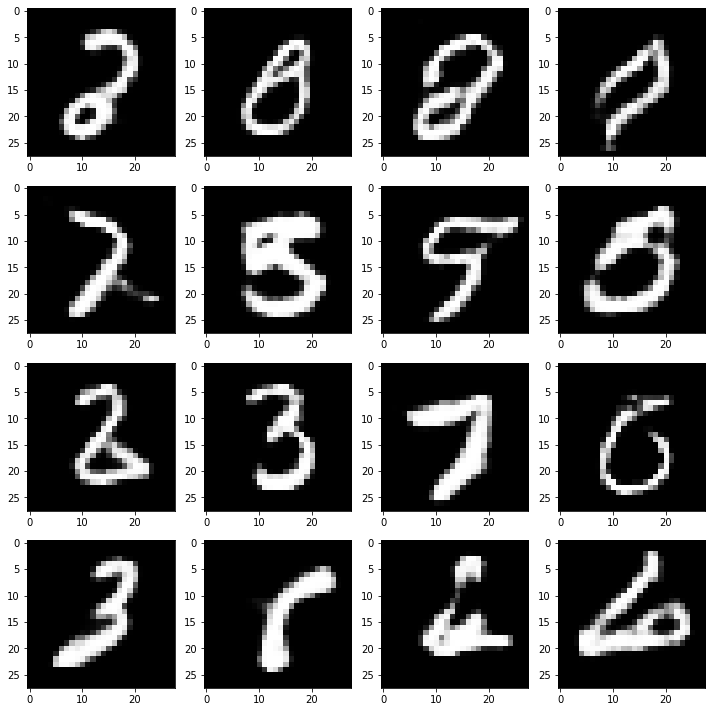

Epoch: 691
Generator Loss: 0.8555096983909607
Discriminator Loss: 1.3308210372924805
Time for epoch 691 is 14.860812902450562 sec
Epoch: 692
Generator Loss: 0.8836838603019714
Discriminator Loss: 1.2407561540603638
Time for epoch 692 is 14.6838698387146 sec
Epoch: 693
Generator Loss: 0.8259717226028442
Discriminator Loss: 1.3492462635040283
Time for epoch 693 is 14.664010524749756 sec
Epoch: 694
Generator Loss: 0.7427076697349548
Discriminator Loss: 1.3472368717193604
Time for epoch 694 is 14.673546314239502 sec
Epoch: 695
Generator Loss: 0.8224669694900513
Discriminator Loss: 1.326289176940918
Time for epoch 695 is 14.68020248413086 sec
Epoch: 696
Generator Loss: 0.8655112981796265
Discriminator Loss: 1.3166817426681519
Time for epoch 696 is 14.674381494522095 sec
Epoch: 697
Generator Loss: 0.8928868174552917
Discriminator Loss: 1.1974256038665771
Time for epoch 697 is 14.669183731079102 sec
Epoch: 698
Generator Loss: 0.8655533194541931
Discriminator Loss: 1.342625617980957
Time for e

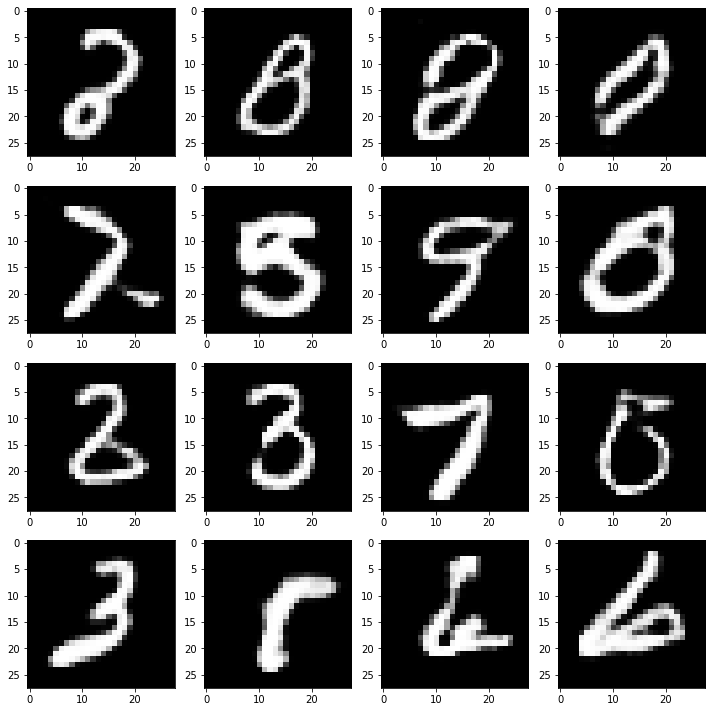

Epoch: 706
Generator Loss: 0.8405237197875977
Discriminator Loss: 1.268484354019165
Time for epoch 706 is 14.818242311477661 sec
Epoch: 707
Generator Loss: 0.8974332213401794
Discriminator Loss: 1.1834535598754883
Time for epoch 707 is 14.668480634689331 sec
Epoch: 708
Generator Loss: 0.8438645005226135
Discriminator Loss: 1.3163070678710938
Time for epoch 708 is 14.671324491500854 sec
Epoch: 709
Generator Loss: 0.8182520866394043
Discriminator Loss: 1.3627409934997559
Time for epoch 709 is 14.696453332901001 sec
Epoch: 710
Generator Loss: 0.8908600807189941
Discriminator Loss: 1.2290209531784058
Time for epoch 710 is 14.68111515045166 sec
Epoch: 711
Generator Loss: 0.8913694024085999
Discriminator Loss: 1.2341089248657227
Time for epoch 711 is 14.676804304122925 sec
Epoch: 712
Generator Loss: 0.9063280820846558
Discriminator Loss: 1.2631505727767944
Time for epoch 712 is 14.7095205783844 sec
Epoch: 713
Generator Loss: 0.8409470915794373
Discriminator Loss: 1.2661486864089966
Time for 

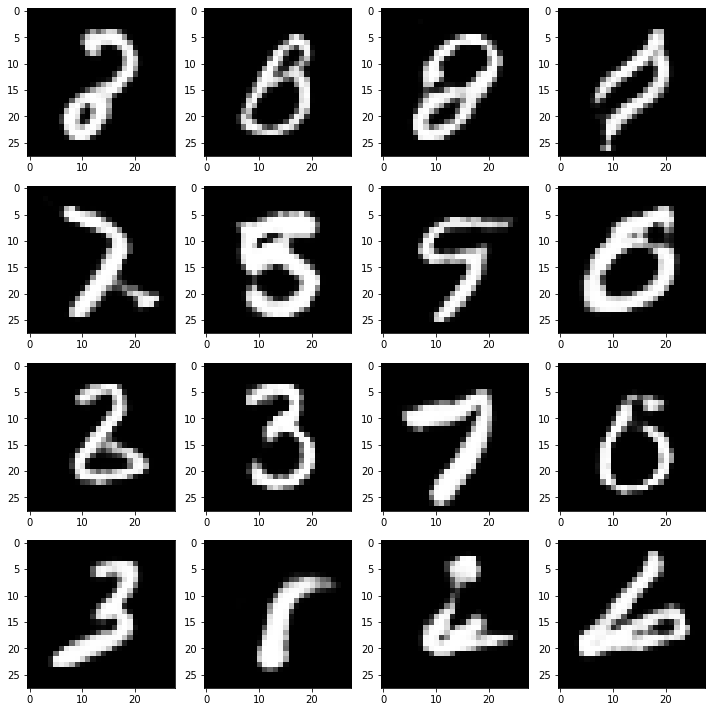

Epoch: 721
Generator Loss: 0.8121932148933411
Discriminator Loss: 1.3081727027893066
Time for epoch 721 is 14.847987651824951 sec
Epoch: 722
Generator Loss: 0.9213775396347046
Discriminator Loss: 1.2695739269256592
Time for epoch 722 is 14.679900407791138 sec
Epoch: 723
Generator Loss: 0.7736924886703491
Discriminator Loss: 1.3587236404418945
Time for epoch 723 is 14.701929569244385 sec
Epoch: 724
Generator Loss: 0.8308512568473816
Discriminator Loss: 1.328235387802124
Time for epoch 724 is 14.654957056045532 sec
Epoch: 725
Generator Loss: 0.8654929399490356
Discriminator Loss: 1.2759337425231934
Time for epoch 725 is 14.64314341545105 sec
Epoch: 726
Generator Loss: 0.8157767057418823
Discriminator Loss: 1.332385540008545
Time for epoch 726 is 14.659909725189209 sec
Epoch: 727
Generator Loss: 0.9017711281776428
Discriminator Loss: 1.2562565803527832
Time for epoch 727 is 14.690614700317383 sec
Epoch: 728
Generator Loss: 0.8128215074539185
Discriminator Loss: 1.342691421508789
Time for 

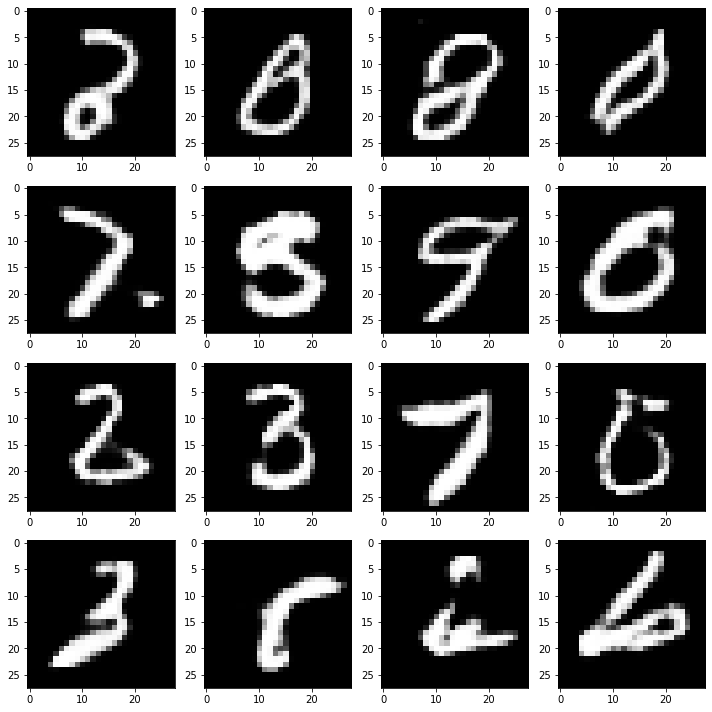

Epoch: 736
Generator Loss: 0.893968939781189
Discriminator Loss: 1.2105696201324463
Time for epoch 736 is 14.745077848434448 sec
Epoch: 737
Generator Loss: 0.8635401725769043
Discriminator Loss: 1.3155665397644043
Time for epoch 737 is 14.66873550415039 sec
Epoch: 738
Generator Loss: 0.8227061033248901
Discriminator Loss: 1.2323426008224487
Time for epoch 738 is 14.720025300979614 sec
Epoch: 739
Generator Loss: 0.7987775206565857
Discriminator Loss: 1.2687773704528809
Time for epoch 739 is 14.65696096420288 sec
Epoch: 740
Generator Loss: 0.8735255002975464
Discriminator Loss: 1.317742943763733
Time for epoch 740 is 14.705601930618286 sec
Epoch: 741
Generator Loss: 0.81431645154953
Discriminator Loss: 1.3386549949645996
Time for epoch 741 is 14.642422914505005 sec
Epoch: 742
Generator Loss: 0.8657421469688416
Discriminator Loss: 1.3191808462142944
Time for epoch 742 is 14.631896257400513 sec
Epoch: 743
Generator Loss: 0.9335190057754517
Discriminator Loss: 1.3229339122772217
Time for ep

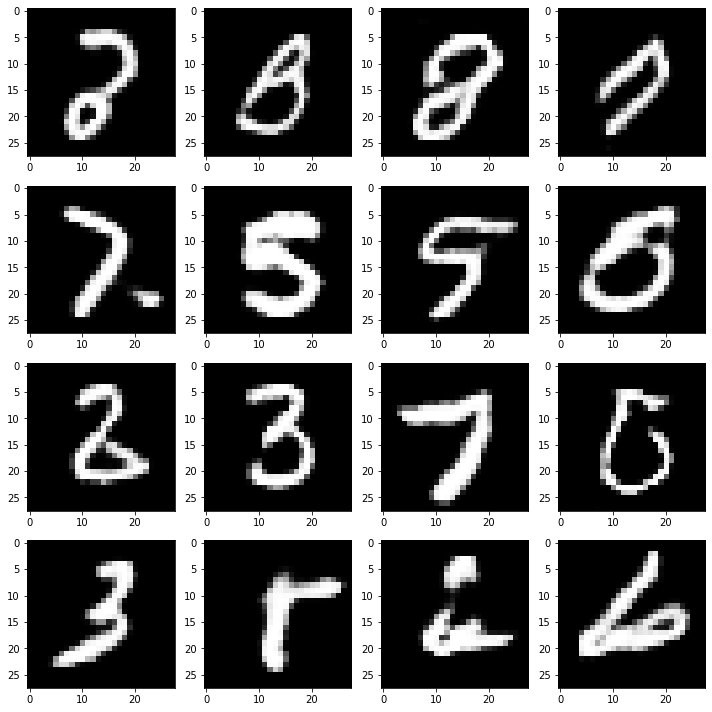

Epoch: 751
Generator Loss: 0.7802014946937561
Discriminator Loss: 1.342885971069336
Time for epoch 751 is 14.799437999725342 sec
Epoch: 752
Generator Loss: 0.76822829246521
Discriminator Loss: 1.3341859579086304
Time for epoch 752 is 14.686854600906372 sec
Epoch: 753
Generator Loss: 0.8816500902175903
Discriminator Loss: 1.3545799255371094
Time for epoch 753 is 14.64989447593689 sec
Epoch: 754
Generator Loss: 0.871240496635437
Discriminator Loss: 1.2931773662567139
Time for epoch 754 is 14.664530277252197 sec
Epoch: 755
Generator Loss: 0.749915361404419
Discriminator Loss: 1.389110803604126
Time for epoch 755 is 14.660930871963501 sec
Epoch: 756
Generator Loss: 0.8335033059120178
Discriminator Loss: 1.2702349424362183
Time for epoch 756 is 15.09080719947815 sec
Epoch: 757
Generator Loss: 0.8756114840507507
Discriminator Loss: 1.3030641078948975
Time for epoch 757 is 15.008965969085693 sec
Epoch: 758
Generator Loss: 0.8519372940063477
Discriminator Loss: 1.2788724899291992
Time for epoc

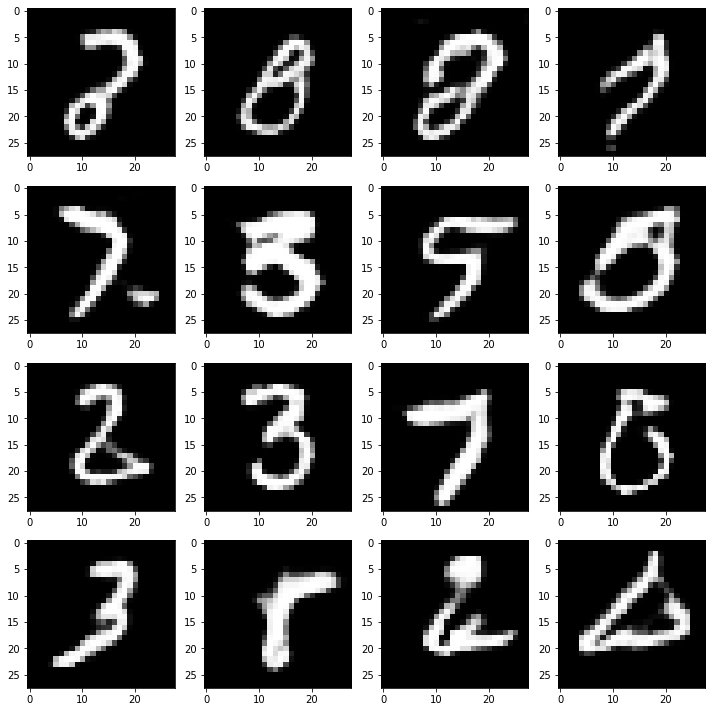

Epoch: 766
Generator Loss: 0.8184027075767517
Discriminator Loss: 1.3125215768814087
Time for epoch 766 is 14.744378805160522 sec
Epoch: 767
Generator Loss: 0.7937980890274048
Discriminator Loss: 1.3650941848754883
Time for epoch 767 is 14.762124300003052 sec
Epoch: 768
Generator Loss: 0.8397912383079529
Discriminator Loss: 1.3118081092834473
Time for epoch 768 is 14.652164936065674 sec
Epoch: 769
Generator Loss: 0.8621663451194763
Discriminator Loss: 1.3008607625961304
Time for epoch 769 is 14.628100633621216 sec
Epoch: 770
Generator Loss: 0.8124052286148071
Discriminator Loss: 1.2980917692184448
Time for epoch 770 is 14.702724933624268 sec
Epoch: 771
Generator Loss: 0.8630240559577942
Discriminator Loss: 1.2950952053070068
Time for epoch 771 is 14.71309494972229 sec
Epoch: 772
Generator Loss: 0.868589460849762
Discriminator Loss: 1.2066600322723389
Time for epoch 772 is 14.691354274749756 sec
Epoch: 773
Generator Loss: 0.8431737422943115
Discriminator Loss: 1.3618160486221313
Time fo

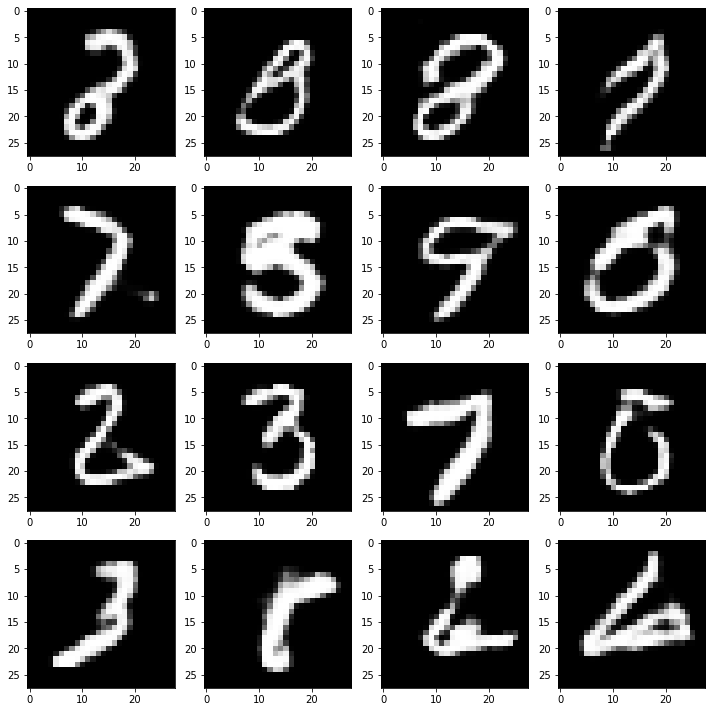

Epoch: 781
Generator Loss: 0.8164783716201782
Discriminator Loss: 1.2490143775939941
Time for epoch 781 is 14.80946135520935 sec
Epoch: 782
Generator Loss: 0.8247342109680176
Discriminator Loss: 1.4117467403411865
Time for epoch 782 is 14.647846460342407 sec
Epoch: 783
Generator Loss: 0.9444788694381714
Discriminator Loss: 1.2263256311416626
Time for epoch 783 is 14.673915386199951 sec
Epoch: 784
Generator Loss: 0.894512414932251
Discriminator Loss: 1.3335981369018555
Time for epoch 784 is 14.658951759338379 sec
Epoch: 785
Generator Loss: 0.7573788166046143
Discriminator Loss: 1.3090262413024902
Time for epoch 785 is 14.681293487548828 sec
Epoch: 786
Generator Loss: 0.8804607391357422
Discriminator Loss: 1.3154349327087402
Time for epoch 786 is 14.67088794708252 sec
Epoch: 787
Generator Loss: 0.8782872557640076
Discriminator Loss: 1.3319880962371826
Time for epoch 787 is 14.675414800643921 sec
Epoch: 788
Generator Loss: 0.7974551916122437
Discriminator Loss: 1.2614011764526367
Time for

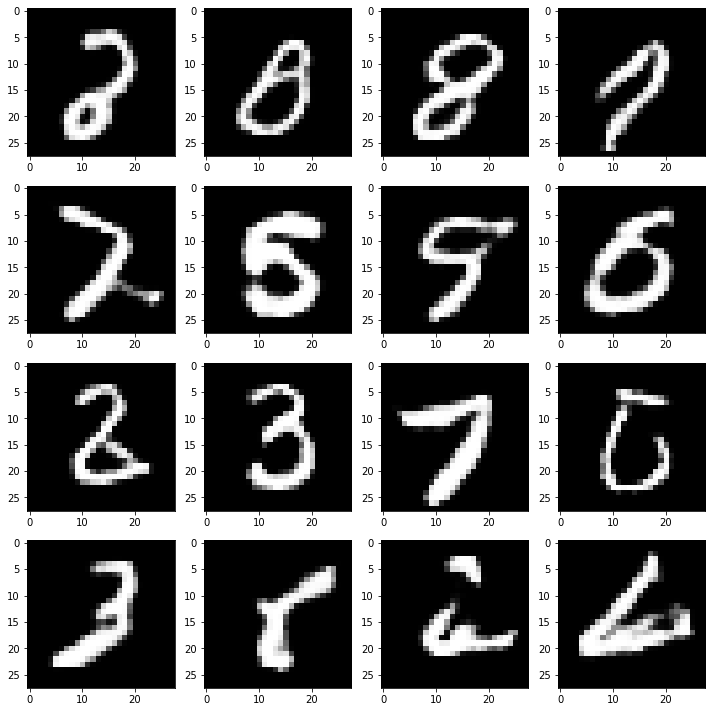

Epoch: 796
Generator Loss: 0.8277468085289001
Discriminator Loss: 1.3606212139129639
Time for epoch 796 is 14.776307582855225 sec
Epoch: 797
Generator Loss: 0.8352147936820984
Discriminator Loss: 1.3504607677459717
Time for epoch 797 is 14.720448970794678 sec
Epoch: 798
Generator Loss: 0.8850733041763306
Discriminator Loss: 1.3178563117980957
Time for epoch 798 is 14.687243461608887 sec
Epoch: 799
Generator Loss: 0.8286215662956238
Discriminator Loss: 1.3648040294647217
Time for epoch 799 is 14.655589580535889 sec
Epoch: 800
Generator Loss: 0.8358839154243469
Discriminator Loss: 1.2009341716766357
Time for epoch 800 is 14.683669567108154 sec
Epoch: 801
Generator Loss: 0.8764606714248657
Discriminator Loss: 1.3214644193649292
Time for epoch 801 is 14.693346500396729 sec
Epoch: 802
Generator Loss: 0.9161665439605713
Discriminator Loss: 1.2541394233703613
Time for epoch 802 is 14.655934810638428 sec
Epoch: 803
Generator Loss: 0.9332060217857361
Discriminator Loss: 1.2879774570465088
Time 

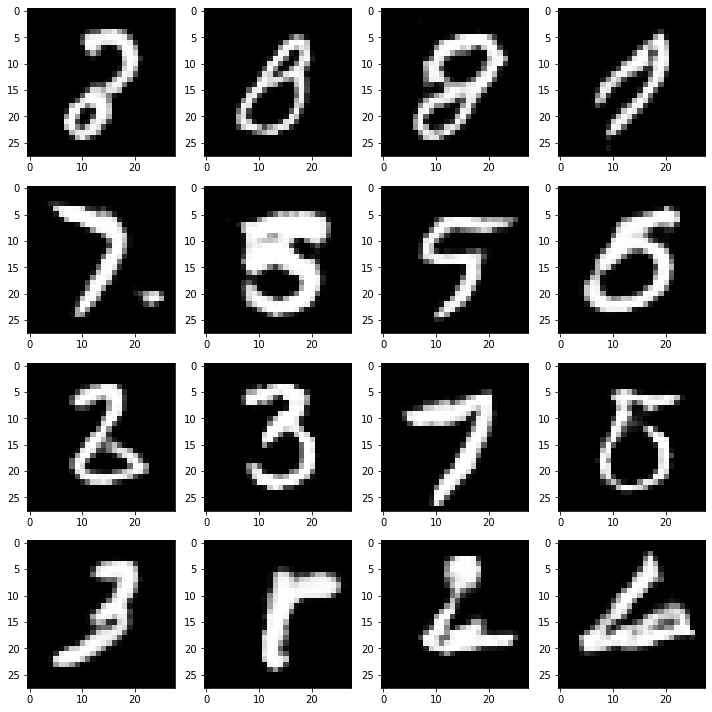

Epoch: 811
Generator Loss: 0.9332553148269653
Discriminator Loss: 1.1700782775878906
Time for epoch 811 is 14.829534769058228 sec
Epoch: 812
Generator Loss: 0.8461035490036011
Discriminator Loss: 1.4029462337493896
Time for epoch 812 is 14.72408151626587 sec
Epoch: 813
Generator Loss: 0.8436456918716431
Discriminator Loss: 1.2318141460418701
Time for epoch 813 is 14.663963079452515 sec
Epoch: 814
Generator Loss: 0.8648665547370911
Discriminator Loss: 1.236167550086975
Time for epoch 814 is 14.667142868041992 sec
Epoch: 815
Generator Loss: 0.8378512263298035
Discriminator Loss: 1.2708001136779785
Time for epoch 815 is 14.667097568511963 sec
Epoch: 816
Generator Loss: 0.847966730594635
Discriminator Loss: 1.3056594133377075
Time for epoch 816 is 14.692097425460815 sec
Epoch: 817
Generator Loss: 0.9735349416732788
Discriminator Loss: 1.1662030220031738
Time for epoch 817 is 14.729336500167847 sec
Epoch: 818
Generator Loss: 0.8654254078865051
Discriminator Loss: 1.2989163398742676
Time for

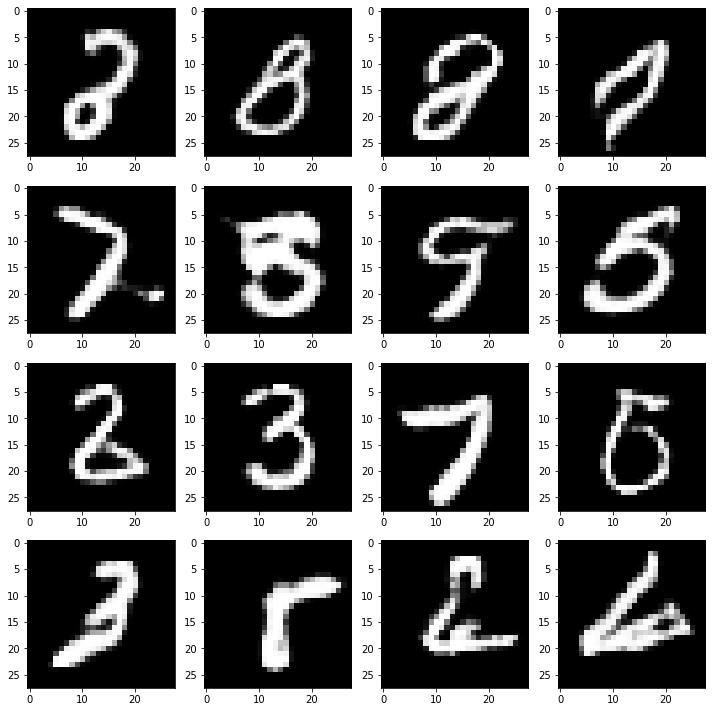

Epoch: 826
Generator Loss: 0.8661896586418152
Discriminator Loss: 1.3207526206970215
Time for epoch 826 is 14.857203006744385 sec
Epoch: 827
Generator Loss: 0.78981614112854
Discriminator Loss: 1.2774946689605713
Time for epoch 827 is 14.713136196136475 sec
Epoch: 828
Generator Loss: 0.8417215347290039
Discriminator Loss: 1.2950509786605835
Time for epoch 828 is 14.67515754699707 sec
Epoch: 829
Generator Loss: 0.954318642616272
Discriminator Loss: 1.2360012531280518
Time for epoch 829 is 14.682490110397339 sec
Epoch: 830
Generator Loss: 0.9588276147842407
Discriminator Loss: 1.1576833724975586
Time for epoch 830 is 14.668982744216919 sec
Epoch: 831
Generator Loss: 0.8652337789535522
Discriminator Loss: 1.2364965677261353
Time for epoch 831 is 14.752785444259644 sec
Epoch: 832
Generator Loss: 0.9002933502197266
Discriminator Loss: 1.3180816173553467
Time for epoch 832 is 14.705839157104492 sec
Epoch: 833
Generator Loss: 0.9288544058799744
Discriminator Loss: 1.349113941192627
Time for e

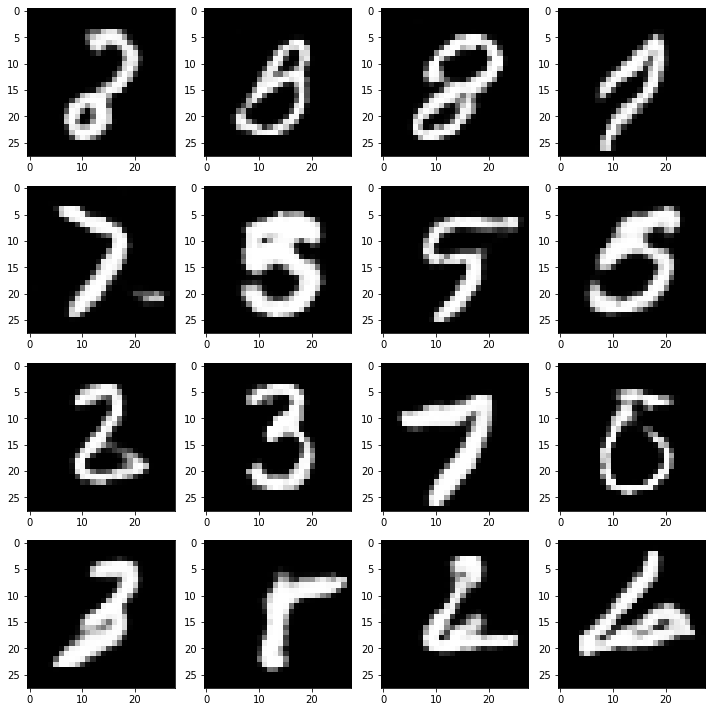

Epoch: 841
Generator Loss: 0.8595275282859802
Discriminator Loss: 1.3106017112731934
Time for epoch 841 is 14.72336745262146 sec
Epoch: 842
Generator Loss: 0.7887445092201233
Discriminator Loss: 1.3857554197311401
Time for epoch 842 is 14.651466369628906 sec
Epoch: 843
Generator Loss: 0.8827915191650391
Discriminator Loss: 1.2873401641845703
Time for epoch 843 is 14.649525165557861 sec
Epoch: 844
Generator Loss: 0.8326078653335571
Discriminator Loss: 1.3263050317764282
Time for epoch 844 is 14.703726530075073 sec
Epoch: 845
Generator Loss: 0.7821143865585327
Discriminator Loss: 1.2647496461868286
Time for epoch 845 is 14.670818328857422 sec
Epoch: 846
Generator Loss: 0.8192024827003479
Discriminator Loss: 1.308732032775879
Time for epoch 846 is 14.698320865631104 sec
Epoch: 847
Generator Loss: 0.885450005531311
Discriminator Loss: 1.3404712677001953
Time for epoch 847 is 14.65151309967041 sec
Epoch: 848
Generator Loss: 0.9641464948654175
Discriminator Loss: 1.1697850227355957
Time for 

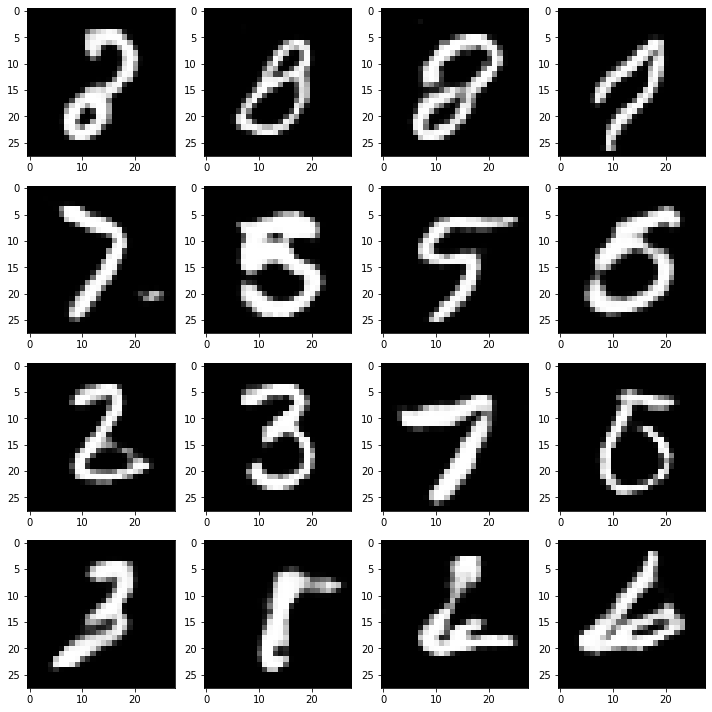

Epoch: 856
Generator Loss: 0.8485258221626282
Discriminator Loss: 1.3208508491516113
Time for epoch 856 is 14.830641984939575 sec
Epoch: 857
Generator Loss: 0.8404773473739624
Discriminator Loss: 1.3054826259613037
Time for epoch 857 is 14.642234325408936 sec
Epoch: 858
Generator Loss: 0.8821321725845337
Discriminator Loss: 1.2018054723739624
Time for epoch 858 is 14.686402797698975 sec
Epoch: 859
Generator Loss: 0.8314915299415588
Discriminator Loss: 1.313273549079895
Time for epoch 859 is 14.670083284378052 sec
Epoch: 860
Generator Loss: 0.8712062239646912
Discriminator Loss: 1.232312798500061
Time for epoch 860 is 14.686577796936035 sec
Epoch: 861
Generator Loss: 0.801837682723999
Discriminator Loss: 1.3095073699951172
Time for epoch 861 is 14.66002082824707 sec
Epoch: 862
Generator Loss: 0.8452752828598022
Discriminator Loss: 1.3774423599243164
Time for epoch 862 is 14.665390014648438 sec
Epoch: 863
Generator Loss: 0.865290105342865
Discriminator Loss: 1.2415119409561157
Time for e

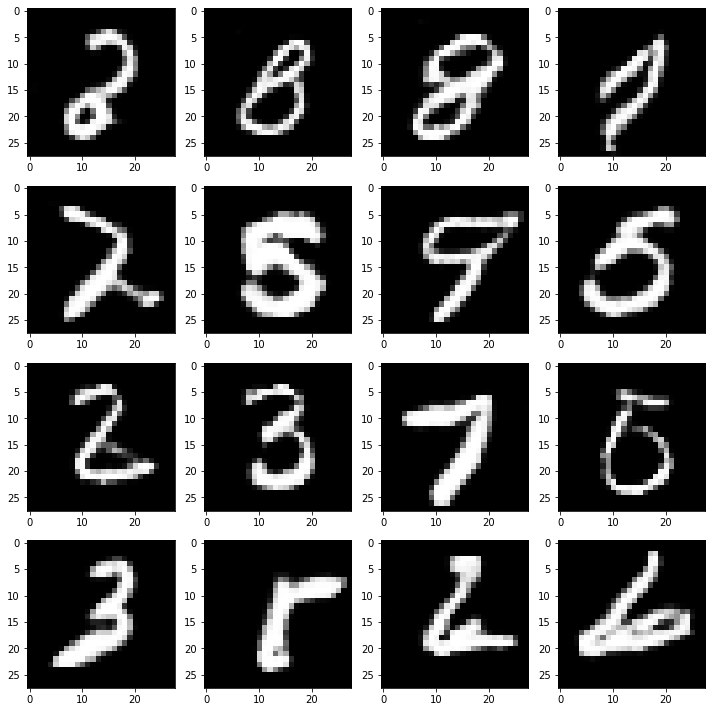

Epoch: 871
Generator Loss: 0.9859947562217712
Discriminator Loss: 1.2539491653442383
Time for epoch 871 is 14.738230466842651 sec
Epoch: 872
Generator Loss: 0.8738531470298767
Discriminator Loss: 1.3134429454803467
Time for epoch 872 is 14.718003749847412 sec
Epoch: 873
Generator Loss: 0.8819329738616943
Discriminator Loss: 1.296506404876709
Time for epoch 873 is 14.691795349121094 sec
Epoch: 874
Generator Loss: 0.8584274053573608
Discriminator Loss: 1.253516674041748
Time for epoch 874 is 14.663408517837524 sec
Epoch: 875
Generator Loss: 0.8670600056648254
Discriminator Loss: 1.2699930667877197
Time for epoch 875 is 14.75406813621521 sec
Epoch: 876
Generator Loss: 0.7393435835838318
Discriminator Loss: 1.351881980895996
Time for epoch 876 is 14.684951782226562 sec
Epoch: 877
Generator Loss: 0.7977950572967529
Discriminator Loss: 1.3340404033660889
Time for epoch 877 is 14.737298965454102 sec
Epoch: 878
Generator Loss: 0.8762747049331665
Discriminator Loss: 1.2487788200378418
Time for 

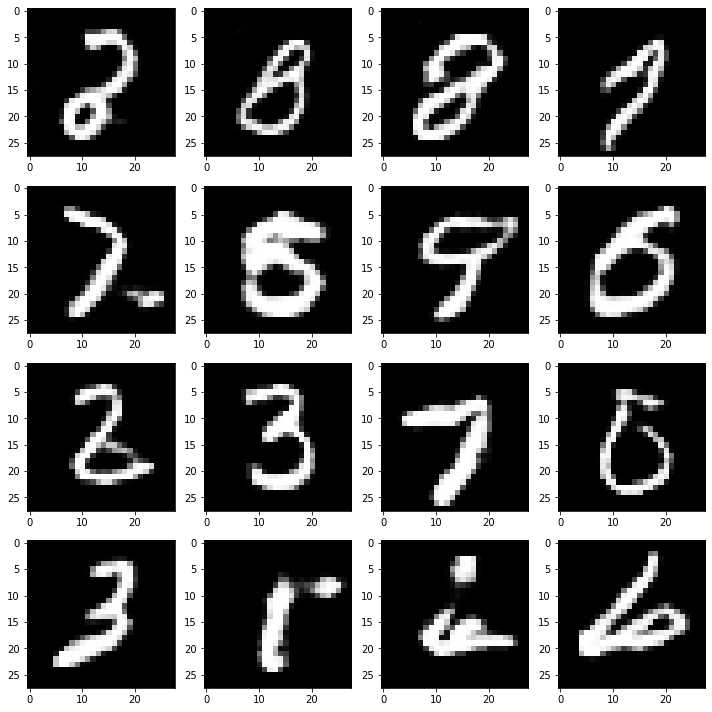

Epoch: 886
Generator Loss: 0.8922439813613892
Discriminator Loss: 1.3120536804199219
Time for epoch 886 is 14.748395204544067 sec
Epoch: 887
Generator Loss: 0.9150531888008118
Discriminator Loss: 1.2256159782409668
Time for epoch 887 is 14.727139711380005 sec
Epoch: 888
Generator Loss: 0.9031509160995483
Discriminator Loss: 1.3761014938354492
Time for epoch 888 is 14.669571161270142 sec
Epoch: 889
Generator Loss: 0.8970159888267517
Discriminator Loss: 1.2437806129455566
Time for epoch 889 is 14.721767663955688 sec
Epoch: 890
Generator Loss: 0.7856851816177368
Discriminator Loss: 1.3926832675933838
Time for epoch 890 is 14.662608861923218 sec
Epoch: 891
Generator Loss: 0.8222139477729797
Discriminator Loss: 1.3514740467071533
Time for epoch 891 is 14.733213901519775 sec
Epoch: 892
Generator Loss: 0.8242659568786621
Discriminator Loss: 1.296743392944336
Time for epoch 892 is 14.681788682937622 sec
Epoch: 893
Generator Loss: 0.9078987836837769
Discriminator Loss: 1.3017081022262573
Time f

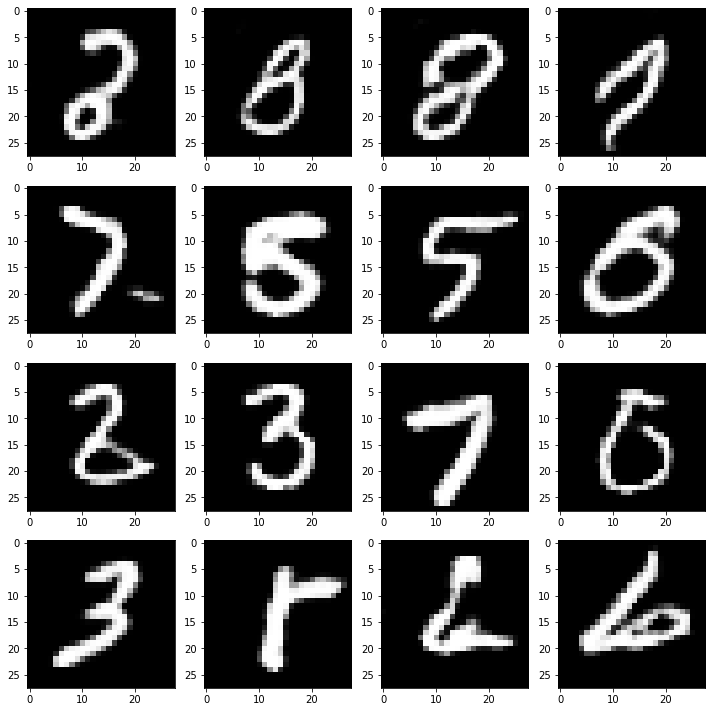

Epoch: 901
Generator Loss: 0.8291277289390564
Discriminator Loss: 1.2776319980621338
Time for epoch 901 is 14.853687047958374 sec
Epoch: 902
Generator Loss: 0.7595871090888977
Discriminator Loss: 1.3424124717712402
Time for epoch 902 is 14.725964307785034 sec
Epoch: 903
Generator Loss: 0.8324409127235413
Discriminator Loss: 1.3532984256744385
Time for epoch 903 is 14.65795087814331 sec
Epoch: 904
Generator Loss: 0.9696889519691467
Discriminator Loss: 1.165315866470337
Time for epoch 904 is 14.623633861541748 sec
Epoch: 905
Generator Loss: 0.9267922639846802
Discriminator Loss: 1.2220209836959839
Time for epoch 905 is 14.656498193740845 sec
Epoch: 906
Generator Loss: 0.8263946771621704
Discriminator Loss: 1.3019976615905762
Time for epoch 906 is 14.720739126205444 sec
Epoch: 907
Generator Loss: 0.8927878141403198
Discriminator Loss: 1.2433574199676514
Time for epoch 907 is 14.66672158241272 sec
Epoch: 908
Generator Loss: 0.8224100470542908
Discriminator Loss: 1.3095996379852295
Time for

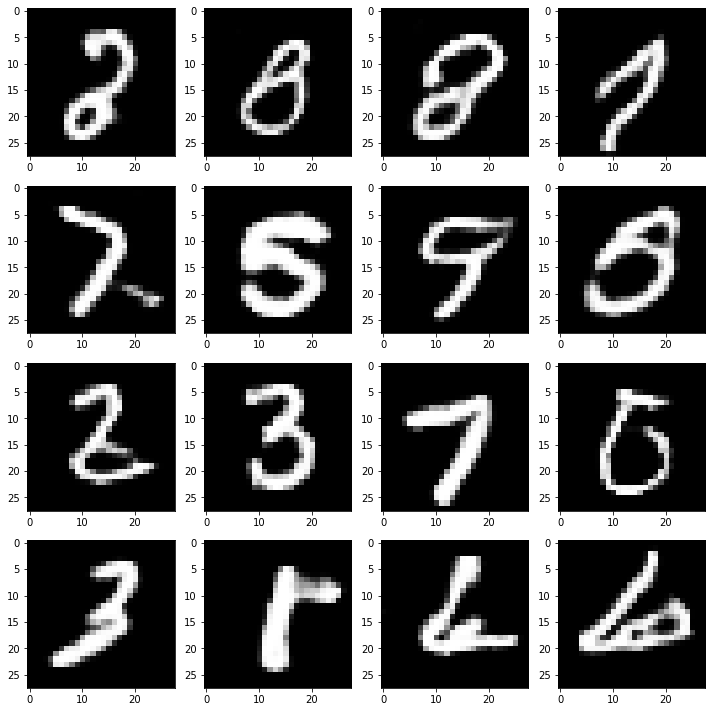

Epoch: 916
Generator Loss: 0.8649231791496277
Discriminator Loss: 1.2731571197509766
Time for epoch 916 is 14.724342107772827 sec
Epoch: 917
Generator Loss: 0.8639839291572571
Discriminator Loss: 1.2817212343215942
Time for epoch 917 is 14.678522109985352 sec
Epoch: 918
Generator Loss: 0.834210216999054
Discriminator Loss: 1.2286200523376465
Time for epoch 918 is 14.694088220596313 sec
Epoch: 919
Generator Loss: 0.909503698348999
Discriminator Loss: 1.212588906288147
Time for epoch 919 is 14.675997734069824 sec
Epoch: 920
Generator Loss: 0.8337118625640869
Discriminator Loss: 1.230379343032837
Time for epoch 920 is 14.666497945785522 sec
Epoch: 921
Generator Loss: 0.7777801752090454
Discriminator Loss: 1.298616647720337
Time for epoch 921 is 14.693840980529785 sec
Epoch: 922
Generator Loss: 0.8274787664413452
Discriminator Loss: 1.324095368385315
Time for epoch 922 is 14.679480075836182 sec
Epoch: 923
Generator Loss: 0.9025816321372986
Discriminator Loss: 1.2404146194458008
Time for ep

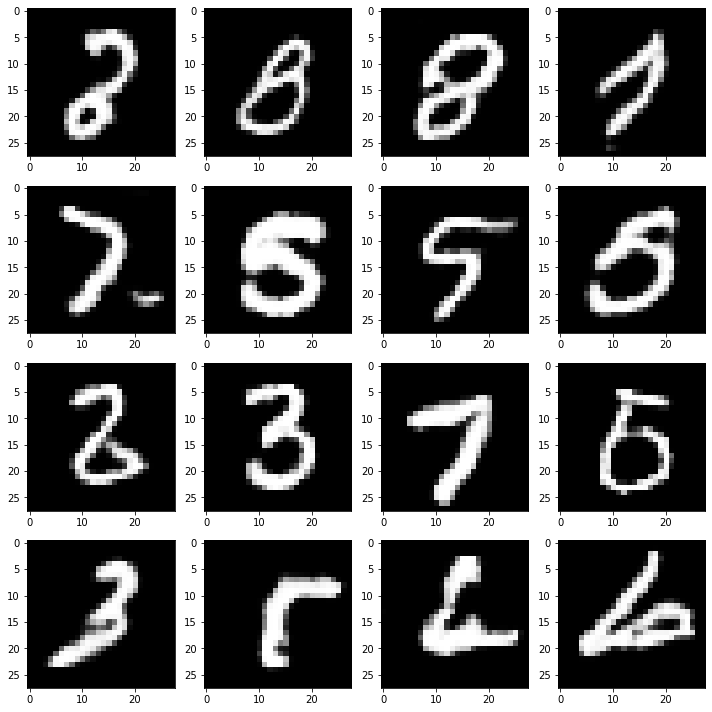

Epoch: 931
Generator Loss: 0.9155219793319702
Discriminator Loss: 1.1819031238555908
Time for epoch 931 is 14.885958671569824 sec
Epoch: 932
Generator Loss: 0.8242812156677246
Discriminator Loss: 1.243117332458496
Time for epoch 932 is 14.668099164962769 sec
Epoch: 933
Generator Loss: 0.8871333003044128
Discriminator Loss: 1.3165663480758667
Time for epoch 933 is 14.692915201187134 sec
Epoch: 934
Generator Loss: 0.7452108263969421
Discriminator Loss: 1.2601373195648193
Time for epoch 934 is 14.69171929359436 sec
Epoch: 935
Generator Loss: 0.8331890106201172
Discriminator Loss: 1.2836649417877197
Time for epoch 935 is 14.67430305480957 sec
Epoch: 936
Generator Loss: 0.793611466884613
Discriminator Loss: 1.3256951570510864
Time for epoch 936 is 14.652986526489258 sec
Epoch: 937
Generator Loss: 0.878838300704956
Discriminator Loss: 1.3166890144348145
Time for epoch 937 is 14.662644863128662 sec
Epoch: 938
Generator Loss: 0.908103883266449
Discriminator Loss: 1.2359516620635986
Time for ep

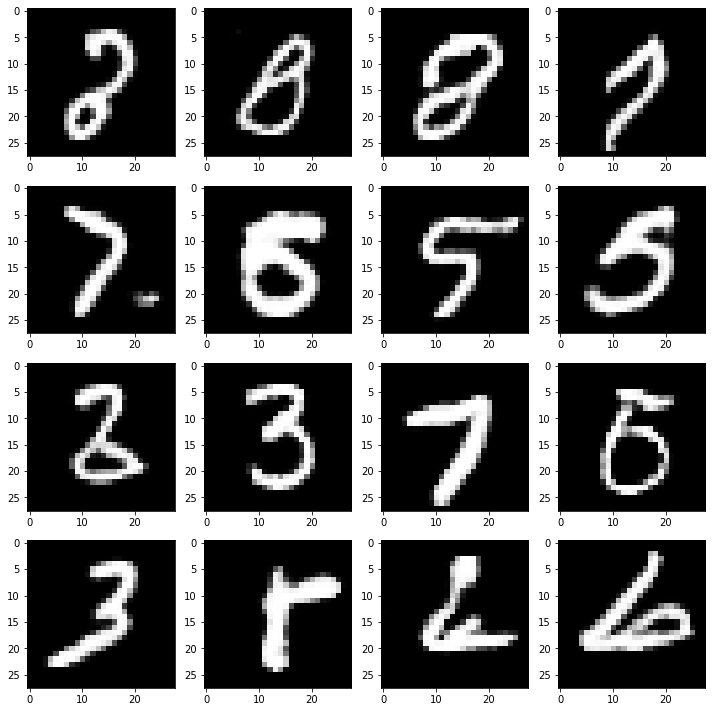

Epoch: 946
Generator Loss: 0.7868044972419739
Discriminator Loss: 1.3696444034576416
Time for epoch 946 is 14.788504600524902 sec
Epoch: 947
Generator Loss: 0.7450394630432129
Discriminator Loss: 1.3370318412780762
Time for epoch 947 is 14.676122426986694 sec
Epoch: 948
Generator Loss: 0.8706704378128052
Discriminator Loss: 1.277847409248352
Time for epoch 948 is 14.679885625839233 sec
Epoch: 949
Generator Loss: 0.9061703085899353
Discriminator Loss: 1.2589163780212402
Time for epoch 949 is 14.692472219467163 sec
Epoch: 950
Generator Loss: 0.8647729158401489
Discriminator Loss: 1.2455182075500488
Time for epoch 950 is 14.714438438415527 sec
Epoch: 951
Generator Loss: 0.9106652736663818
Discriminator Loss: 1.1874518394470215
Time for epoch 951 is 14.689858675003052 sec
Epoch: 952
Generator Loss: 0.7691730856895447
Discriminator Loss: 1.348301887512207
Time for epoch 952 is 14.751462459564209 sec
Epoch: 953
Generator Loss: 0.8108469247817993
Discriminator Loss: 1.307273268699646
Time for

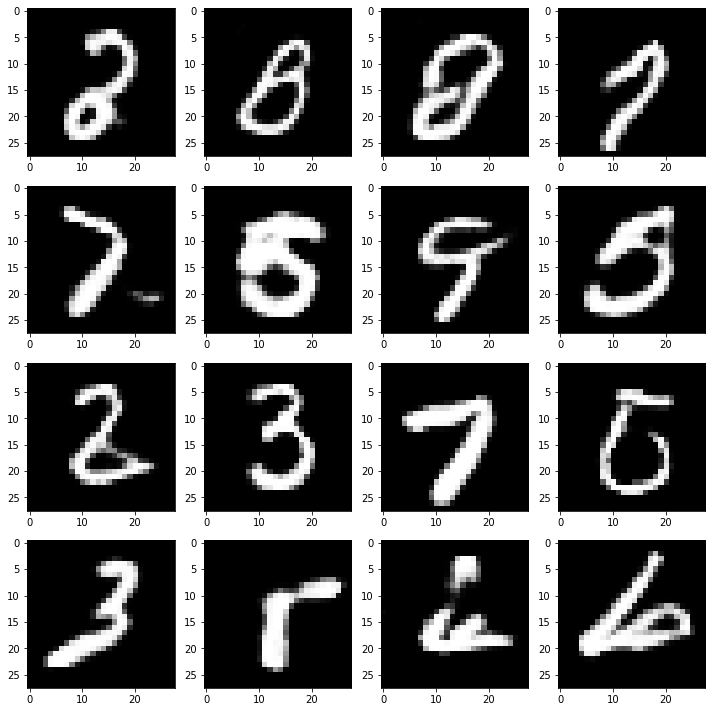

Epoch: 961
Generator Loss: 1.012999176979065
Discriminator Loss: 1.2022273540496826
Time for epoch 961 is 14.836948156356812 sec
Epoch: 962
Generator Loss: 0.8152258992195129
Discriminator Loss: 1.3140678405761719
Time for epoch 962 is 14.719579458236694 sec
Epoch: 963
Generator Loss: 0.8451333045959473
Discriminator Loss: 1.2651259899139404
Time for epoch 963 is 14.731258869171143 sec
Epoch: 964
Generator Loss: 0.898319661617279
Discriminator Loss: 1.1794993877410889
Time for epoch 964 is 14.646188020706177 sec
Epoch: 965
Generator Loss: 0.9188659191131592
Discriminator Loss: 1.3229084014892578
Time for epoch 965 is 14.663161993026733 sec
Epoch: 966
Generator Loss: 0.8234505653381348
Discriminator Loss: 1.299243450164795
Time for epoch 966 is 14.688658714294434 sec
Epoch: 967
Generator Loss: 0.8970582485198975
Discriminator Loss: 1.2369155883789062
Time for epoch 967 is 14.66322660446167 sec
Epoch: 968
Generator Loss: 0.8186780214309692
Discriminator Loss: 1.327362298965454
Time for e

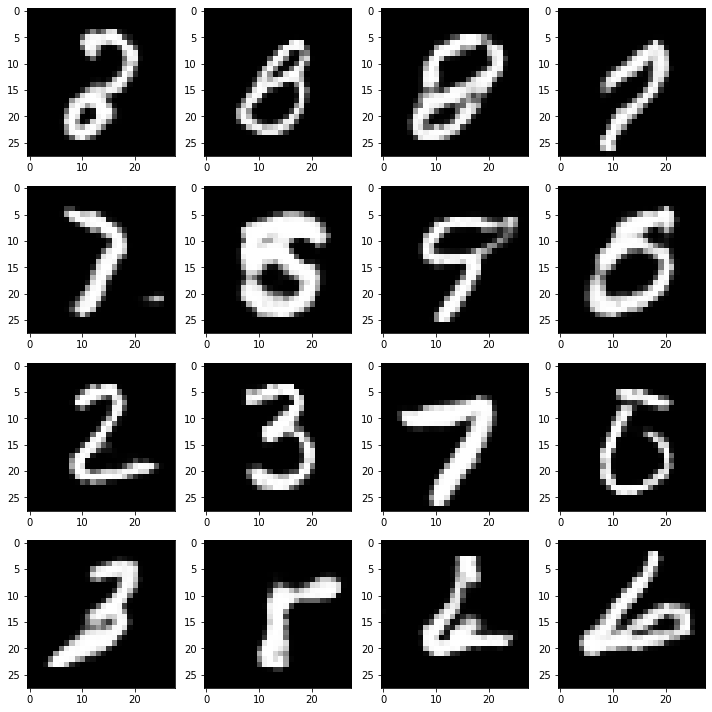

Epoch: 976
Generator Loss: 0.8406774997711182
Discriminator Loss: 1.3880400657653809
Time for epoch 976 is 14.764419317245483 sec
Epoch: 977
Generator Loss: 0.8020557761192322
Discriminator Loss: 1.2460190057754517
Time for epoch 977 is 14.665343999862671 sec
Epoch: 978
Generator Loss: 0.8202461004257202
Discriminator Loss: 1.378554105758667
Time for epoch 978 is 14.694969177246094 sec
Epoch: 979
Generator Loss: 0.8608344197273254
Discriminator Loss: 1.2633163928985596
Time for epoch 979 is 14.68029260635376 sec
Epoch: 980
Generator Loss: 0.8614654541015625
Discriminator Loss: 1.2874112129211426
Time for epoch 980 is 14.673513412475586 sec
Epoch: 981
Generator Loss: 0.952129602432251
Discriminator Loss: 1.2608349323272705
Time for epoch 981 is 14.663214445114136 sec
Epoch: 982
Generator Loss: 0.8205864429473877
Discriminator Loss: 1.2631449699401855
Time for epoch 982 is 14.669251918792725 sec
Epoch: 983
Generator Loss: 0.7879865765571594
Discriminator Loss: 1.2517259120941162
Time for

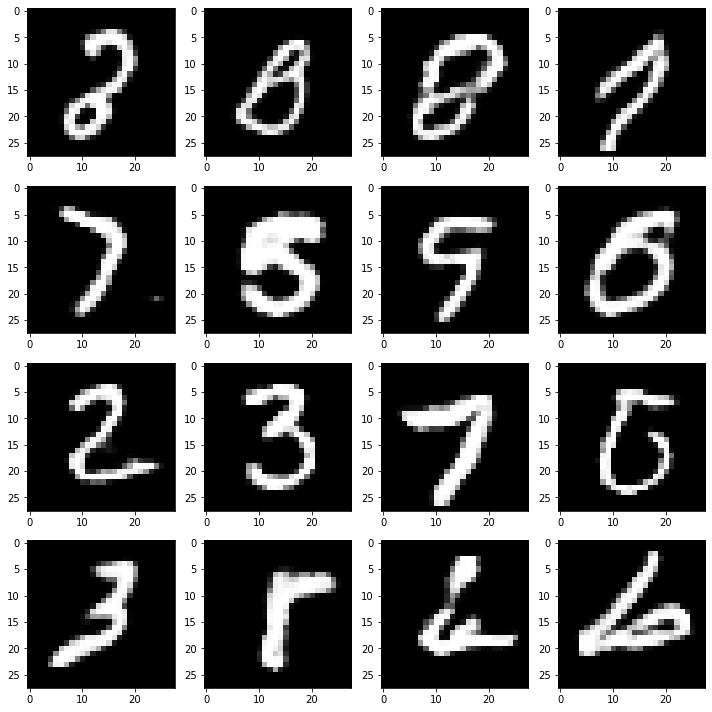

Epoch: 991
Generator Loss: 0.8036595582962036
Discriminator Loss: 1.2505419254302979
Time for epoch 991 is 14.77917194366455 sec
Epoch: 992
Generator Loss: 0.8707365393638611
Discriminator Loss: 1.308117151260376
Time for epoch 992 is 14.684264183044434 sec
Epoch: 993
Generator Loss: 0.8799288868904114
Discriminator Loss: 1.3160401582717896
Time for epoch 993 is 14.692358493804932 sec
Epoch: 994
Generator Loss: 0.8921898007392883
Discriminator Loss: 1.338282823562622
Time for epoch 994 is 14.664851903915405 sec
Epoch: 995
Generator Loss: 0.8020482063293457
Discriminator Loss: 1.3725426197052002
Time for epoch 995 is 14.666473150253296 sec
Epoch: 996
Generator Loss: 0.817496657371521
Discriminator Loss: 1.318939208984375
Time for epoch 996 is 14.637895822525024 sec
Epoch: 997
Generator Loss: 0.8935677409172058
Discriminator Loss: 1.238206148147583
Time for epoch 997 is 14.694404125213623 sec
Epoch: 998
Generator Loss: 0.8478970527648926
Discriminator Loss: 1.1949706077575684
Time for ep

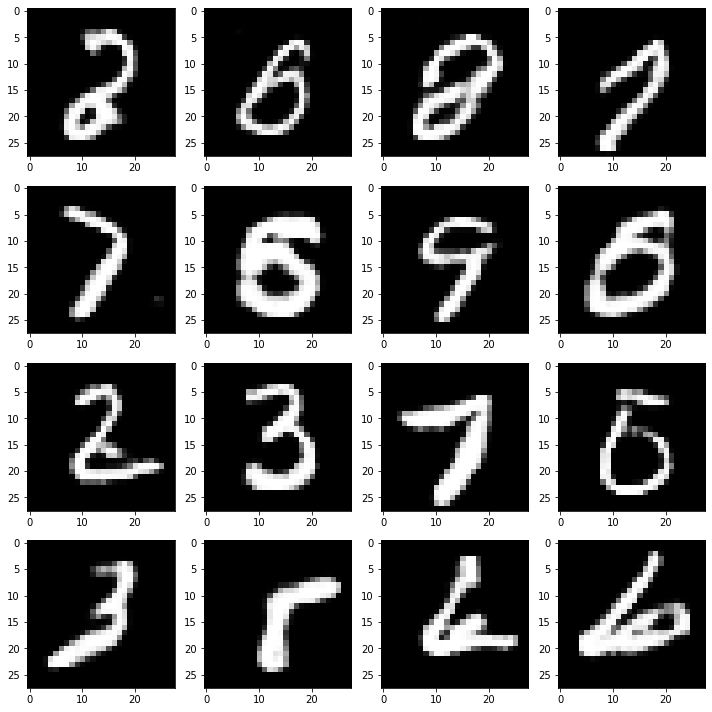

Epoch: 1006
Generator Loss: 0.8810788989067078
Discriminator Loss: 1.1821101903915405
Time for epoch 1006 is 14.708913087844849 sec
Epoch: 1007
Generator Loss: 0.887418806552887
Discriminator Loss: 1.3048529624938965
Time for epoch 1007 is 14.715372562408447 sec
Epoch: 1008
Generator Loss: 0.9058977961540222
Discriminator Loss: 1.2690515518188477
Time for epoch 1008 is 14.686647653579712 sec
Epoch: 1009
Generator Loss: 0.9041602611541748
Discriminator Loss: 1.3089736700057983
Time for epoch 1009 is 14.680341720581055 sec
Epoch: 1010
Generator Loss: 0.8482808470726013
Discriminator Loss: 1.2490780353546143
Time for epoch 1010 is 14.863111734390259 sec
Epoch: 1011
Generator Loss: 0.860792875289917
Discriminator Loss: 1.2578999996185303
Time for epoch 1011 is 14.69916558265686 sec
Epoch: 1012
Generator Loss: 0.854935884475708
Discriminator Loss: 1.305105209350586
Time for epoch 1012 is 14.675840139389038 sec
Epoch: 1013
Generator Loss: 0.8964345455169678
Discriminator Loss: 1.326982736587

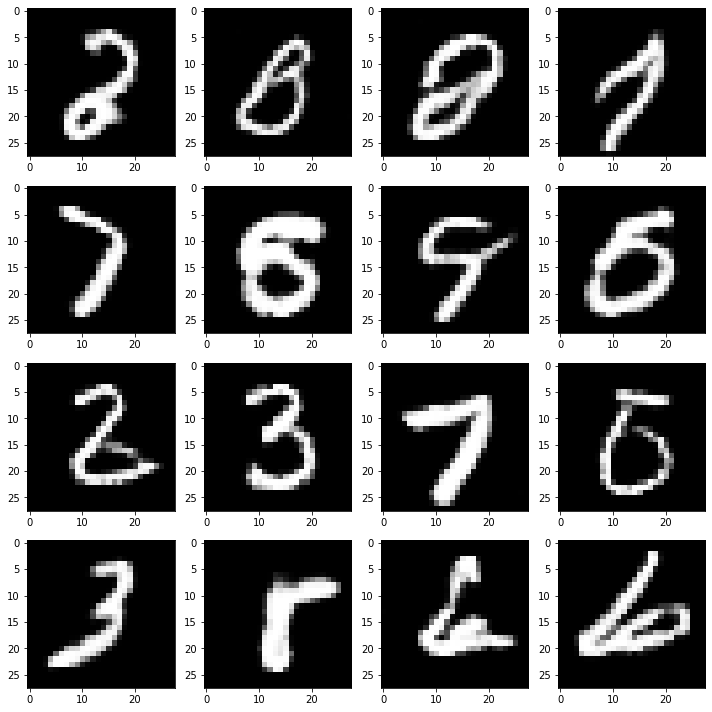

Epoch: 1021
Generator Loss: 0.8873972296714783
Discriminator Loss: 1.328719973564148
Time for epoch 1021 is 14.923718929290771 sec
Epoch: 1022
Generator Loss: 0.7521146535873413
Discriminator Loss: 1.3780674934387207
Time for epoch 1022 is 14.714082956314087 sec
Epoch: 1023
Generator Loss: 0.810187816619873
Discriminator Loss: 1.292844533920288
Time for epoch 1023 is 14.703596115112305 sec
Epoch: 1024
Generator Loss: 0.8716813921928406
Discriminator Loss: 1.3137190341949463
Time for epoch 1024 is 14.681018829345703 sec
Epoch: 1025
Generator Loss: 0.7690549492835999
Discriminator Loss: 1.302931308746338
Time for epoch 1025 is 14.66790771484375 sec
Epoch: 1026
Generator Loss: 0.7661243677139282
Discriminator Loss: 1.291142463684082
Time for epoch 1026 is 14.677439212799072 sec
Epoch: 1027
Generator Loss: 0.8008147478103638
Discriminator Loss: 1.3589036464691162
Time for epoch 1027 is 14.695215463638306 sec
Epoch: 1028
Generator Loss: 0.8013709783554077
Discriminator Loss: 1.3738902807235

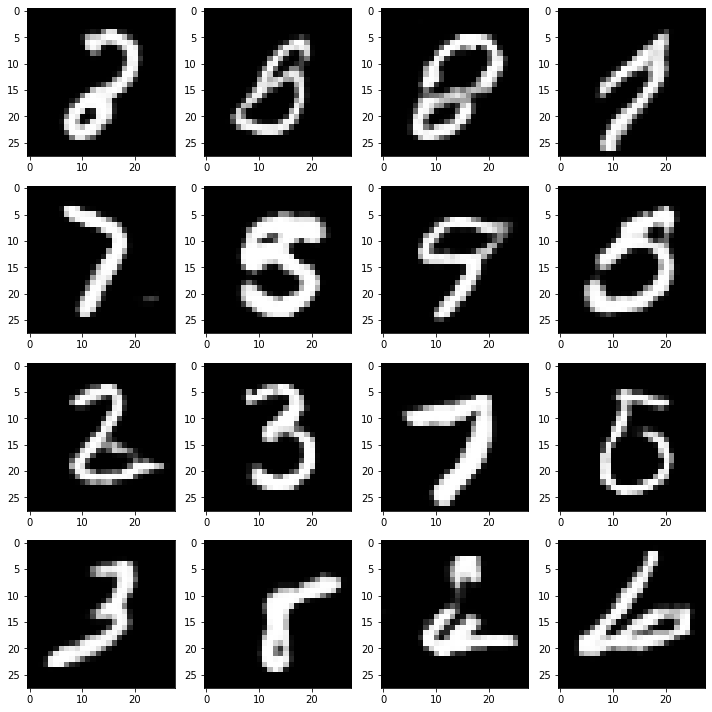

Epoch: 1036
Generator Loss: 0.8472499847412109
Discriminator Loss: 1.2836666107177734
Time for epoch 1036 is 14.788375854492188 sec
Epoch: 1037
Generator Loss: 0.8281400799751282
Discriminator Loss: 1.2547019720077515
Time for epoch 1037 is 14.719109058380127 sec
Epoch: 1038
Generator Loss: 0.9278420209884644
Discriminator Loss: 1.290185570716858
Time for epoch 1038 is 14.698866844177246 sec
Epoch: 1039
Generator Loss: 0.8454498052597046
Discriminator Loss: 1.3337804079055786
Time for epoch 1039 is 14.691210985183716 sec
Epoch: 1040
Generator Loss: 0.8676519393920898
Discriminator Loss: 1.3434149026870728
Time for epoch 1040 is 14.708699703216553 sec
Epoch: 1041
Generator Loss: 0.8869807124137878
Discriminator Loss: 1.2842464447021484
Time for epoch 1041 is 14.637770891189575 sec
Epoch: 1042
Generator Loss: 0.8343501687049866
Discriminator Loss: 1.3869221210479736
Time for epoch 1042 is 14.648731231689453 sec
Epoch: 1043
Generator Loss: 0.8716872930526733
Discriminator Loss: 1.27305698

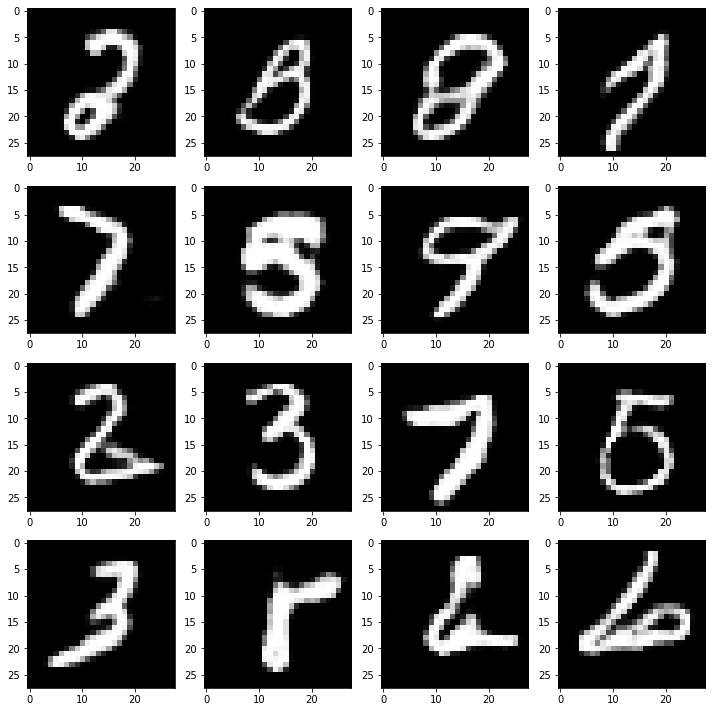

Epoch: 1051
Generator Loss: 0.8459084033966064
Discriminator Loss: 1.2514419555664062
Time for epoch 1051 is 14.852479934692383 sec
Epoch: 1052
Generator Loss: 0.9462603330612183
Discriminator Loss: 1.2696504592895508
Time for epoch 1052 is 14.701041460037231 sec
Epoch: 1053
Generator Loss: 0.8461953401565552
Discriminator Loss: 1.3258802890777588
Time for epoch 1053 is 14.680710554122925 sec
Epoch: 1054
Generator Loss: 0.8365139365196228
Discriminator Loss: 1.2493622303009033
Time for epoch 1054 is 14.703651666641235 sec
Epoch: 1055
Generator Loss: 0.7943385243415833
Discriminator Loss: 1.4555538892745972
Time for epoch 1055 is 14.700362205505371 sec
Epoch: 1056
Generator Loss: 0.7733355164527893
Discriminator Loss: 1.3248646259307861
Time for epoch 1056 is 14.728302717208862 sec
Epoch: 1057
Generator Loss: 0.9222403168678284
Discriminator Loss: 1.212874412536621
Time for epoch 1057 is 14.720607280731201 sec
Epoch: 1058
Generator Loss: 0.8592329621315002
Discriminator Loss: 1.20691442

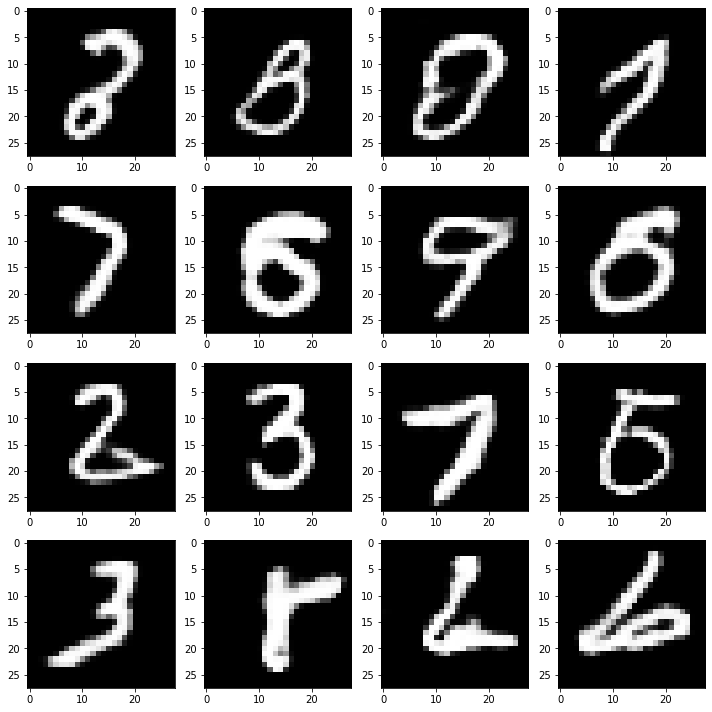

Epoch: 1066
Generator Loss: 0.9094956517219543
Discriminator Loss: 1.2609795331954956
Time for epoch 1066 is 14.867840051651001 sec
Epoch: 1067
Generator Loss: 0.8815094232559204
Discriminator Loss: 1.2157902717590332
Time for epoch 1067 is 14.71704649925232 sec
Epoch: 1068
Generator Loss: 0.795361340045929
Discriminator Loss: 1.2548550367355347
Time for epoch 1068 is 14.742507934570312 sec
Epoch: 1069
Generator Loss: 0.8340829610824585
Discriminator Loss: 1.272504448890686
Time for epoch 1069 is 14.72395634651184 sec
Epoch: 1070
Generator Loss: 0.9052462577819824
Discriminator Loss: 1.2762939929962158
Time for epoch 1070 is 14.735529661178589 sec


Error: Canceled future for execute_request message before replies were done

In [8]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0


        for image_batch in dataset:
            count += 1
            if count == 235:
                train_step(image_batch, 1, epoch)
            else:
                train_step(image_batch, 0, epoch)


        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        generated_images = generator(seed, training=False)
        if (epoch + 1) % 15 == 0:
            print('Generated Images after {} epochs'.format(epoch + 1))
            plt.figure(figsize=(10, 10))
            for i in range(generated_images.shape[0]):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i, :, :, 0], cmap='gray')
                plt.axis('on')
            save_fig(str(epoch + 1))
            plt.show()


tf.config.run_functions_eagerly(True)
train_GAN(train_dataset, 1200)